In [312]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import matplotlib.ticker as mticker
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import numpy as np
from scipy.stats import norm


### Leemos los datos usando la librería Pandas y pasamos los datos de str a float para poder operar con ellos. También definimos delta que se mantiene constante siempre.

In [313]:
datos = pd.read_csv('Wind_data_for_TP1.csv', sep=';', decimal=',')
datos["regional wind"]=datos["regional wind"].astype(float)
datos["wind gap norte sur"]=datos['wind gap norte sur'].astype(float)
delta=1/365

### Ejercicio 1.1: Cálculo de Sigma y Kappa. 

Para estimar $\kappa$ y $\sigma$ hicimosla siguiente transformación:

$$ S_{i+1} = S_i + \kappa (\theta - S_i) \Delta + \sigma \sqrt{\Delta} Z_{i+1} $$

$$ S_{i+1} - S_i = \kappa (\theta - S_i) \Delta + \sigma \sqrt{\Delta} Z_{i+1} $$

Si tomtamos $Y_i = S_{i+1} - S_i$, $X_i = (\theta - S_i) \Delta$ y $c = \sigma \sqrt{\Delta}$ podemos reescribir la ecuación como:

$$ Y_i = \kappa X_i + c \cdot Z_i $$

Si planteamos una regresión lineal obtenemos kappa como el B0 que multiplica a la X y C como la varianza del error de la regresión.

Sabemos que $c = \sqrt{\Delta} \sigma$. Por lo tanto, tenemos que $\sigma = c / \sqrt{\Delta}$.

In [314]:

delta = 1/365
def theta(t_i):
    resultado:float = 6 + 2 * np.cos(2 * np.pi *t_i /365)
    return resultado

#Estimación para regional Wind de Kappa y Sigma 

#Definimos una nueva variable Y como la resta de Si - si-1
Y_RW=(datos["regional wind"][1:]-datos["regional wind"].shift(1)[1:]).values
thetas = np.array([theta(t_i) for t_i in range(len(datos["regional wind"]))])
X_RW=((thetas[1:] -datos["regional wind"][:-1])*delta).values
reg=LinearRegression().fit(X_RW.reshape(-1,1),Y_RW)
Y_pred=reg.predict(X_RW.reshape(-1,1))
error=Y_RW-Y_pred
C=error.var()
kappa=reg.coef_[0]
print("Kappa vale:", kappa)
sigma=np.sqrt(C/delta)
print("Sigma vale:", sigma)


Kappa vale: 109.04125628331596
Sigma vale: 16.044573145393112


### Ejercicio 1.2: Estimación de Beta y Gamma

Para estimar los parámetros \(\beta\) y \(\gamma\) partimos de la siguiente ecuación:

$$
D_{i+1} = D_i - \beta D_i \Delta + \gamma \sqrt{\Delta}W_i
$$

Al restar \(D_i\) en ambos lados, obtenemos:

$$
D_{i+1} - D_i = - \beta D_i \Delta + \gamma \sqrt{\Delta}W_i
$$

A continuación, realizamos una transformación similar a la utilizada en el Ejercicio 1.1. Definimos las siguientes variables:

$$
(Y_i = D_{i+1} - D_i)
$$
$$
(X_i = - D_i \Delta)
$$
$$
(c = \gamma \sqrt{\Delta})
$$


Reescribimos la ecuación de la siguiente manera:

$$
Y_i = \beta X_i + c \cdot \Delta W_i
$$

### Regresión Lineal para Estimar Beta

Planteamos una regresión lineal de \(Y_i\) en función de \(X_i\), lo que nos permitirá estimar \(\beta\) como el coeficiente que multiplica a \(X_i\).

### Estimación de Gamma

Una vez realizada la regresión, obtenemos \(c\) a partir de la varianza del término de error. Sabemos que \(c = \gamma \sqrt{\Delta}\), por lo que podemos despejar \(\gamma\) como:

$$
\gamma = \frac{c}{\sqrt{\Delta}}
$$

In [315]:
#Estimación para wind gap norte sur de beta y gamma
Y_WG=(datos["wind gap norte sur"][1:]-datos["wind gap norte sur"].shift(1)[1:]).values
X_WG=((datos["wind gap norte sur"][:-1])*delta).values
reg=LinearRegression().fit(X_WG.reshape(-1,1),Y_WG)
Y_pred=reg.predict(X_WG.reshape(-1,1))
error=Y_WG-Y_pred
C=error.var()

beta=-reg.coef_[0]
print("Beta vale:", beta)
gamma=np.sqrt(C/delta)
print("Gamma vale:", gamma)

Beta vale: 48.377333231943695
Gamma vale: 10.090719957138331


### Ejercicio 2: Implementamos la simulación para el plazo de un año utilizando los parámetros que despejamos en el ejercicio 1.

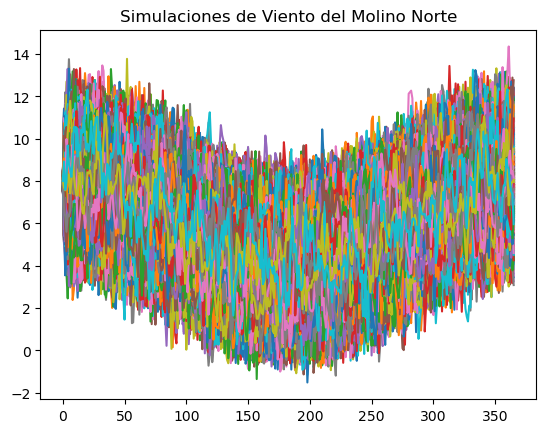

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x107c255e0>>
Traceback (most recent call last):
  File "/Users/jazsneider/miniconda3/envs/TD6/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


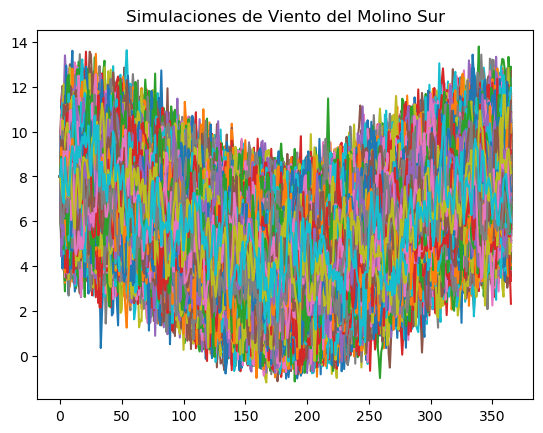

In [316]:
#Definimos una función para simular el viento regional
def simulacion_regional_wind(S_0, kappa, sigma, delta, T, caminos):   
    #Inicializamos matriz S(M CAMINOS * T TIEMPOS)
    S=np.zeros((caminos,T+1))
    #ponemos en todas las filas primera posición el so
    S[:,0]=S_0
    #para cada fila
    for camino in range (caminos):
        #calculamos todos los tiempos
        for i in range(1,T+1):
            #pongo el maximo entre 0 y el estimado por si llegara a darme negativo algún viento
            S[camino,i]=max(0,S[camino,i-1]+kappa*(theta(i)-S[camino,i-1])*delta+(sigma*np.sqrt(delta)*np.random.normal(0,1)))
    return S

#Definimos una simulación para simular la diferencia entre las regiones
def simulacion_wind_gap_norte_sur(D_0,beta, gamma, delta, T, caminos):
    D=np.zeros((caminos,T+1))
    D[:,0]=D_0
    for camino in range (caminos):
        #calculamos todos los tiempos
        for i in range(1,T+1):
            #Calculamos la variacion del viento entre el molino norte y sur
            D[camino,i]=D[camino,i-1]-beta*D[camino,i-1]*delta+(gamma*np.sqrt(delta)*np.random.normal(0,1))
    return D

#Definimos una función que combina las anteriores y devuelve las simulaciones de viento para ambos molinos.
def simulacion_viento_molinos(S_0, D_0,kappa,sigma,delta,gamma,beta,T,caminos):
    S = simulacion_regional_wind(S_0,kappa,sigma,delta,T,caminos)
    D = simulacion_wind_gap_norte_sur(D_0,beta,gamma,delta,T,caminos)
    S_Molino_Sur = (S[:,:] + 0.5*D[:,:])
    S_Molino_Norte = (S[:,:] - 0.5*D[:,:])
    return S_Molino_Norte, S_Molino_Sur

#implementamos una simulación de 10000 caminos para un año
simulaciones_norte,simulaciones_sur=simulacion_viento_molinos(datos['regional wind'][0],datos["wind gap norte sur"][0],kappa,sigma,delta,gamma,beta,365,10000)
for simulacion_n in simulaciones_norte:
    plt.plot(simulacion_n)
plt.title("Simulaciones de Viento del Molino Norte")
plt.show()

for simulacion_s in simulaciones_sur:
    plt.plot(simulacion_s)
plt.title("Simulaciones de Viento del Molino Sur")
plt.show()


Ahora vamos a comprobar si la media de las simulaciones que hicimos es similar a la data histórica

In [ ]:
#Calculamos la media de las simulaciones del viento para el norte y para el sur.
media_viento_norte=[]
for dia in range(0,366):
    media_viento_norte.append(simulaciones_norte[:,dia].mean())
media_viento_sur=[]
for dia in range(0,366):
    media_viento_sur.append(simulaciones_sur[:,dia].mean())

#Ahora obtenemos los datos históricos
datos_historicos_norte=[]
for dia in range(0,366):
    datos_historicos_norte.append(datos['regional wind'][dia]-(1/2*datos['wind gap norte sur'][dia]))

datos_historicos_sur=[]
for dia in range(0,366):
    datos_historicos_sur.append(datos['regional wind'][dia]+(1/2*datos['wind gap norte sur'][dia]))

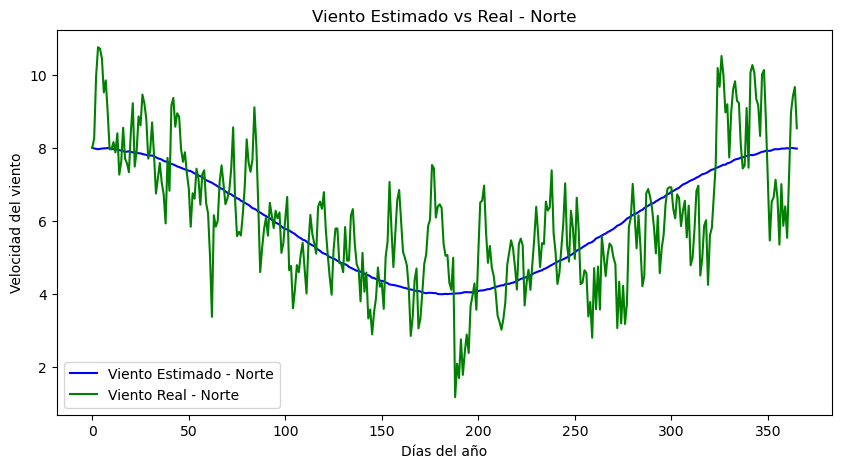

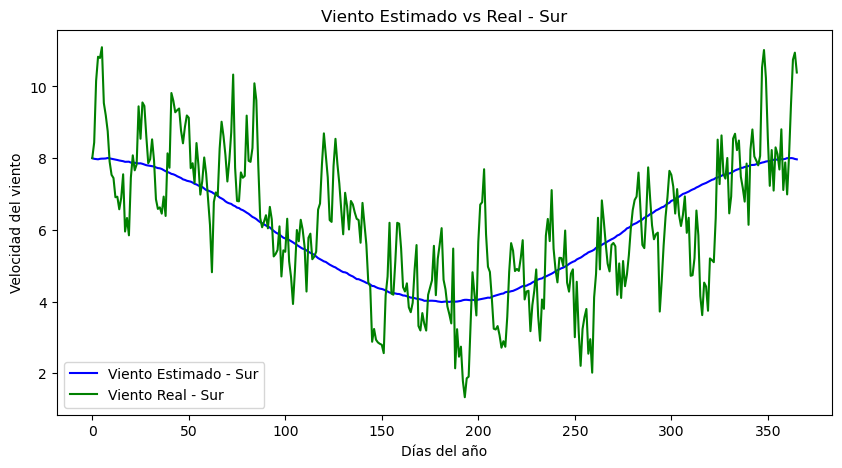

In [ ]:
# Gráfico para el viento en el norte
plt.figure(figsize=(10, 5))

# Graficamos el viento estimado (media de las simulaciones)
plt.plot(range(0, 366), media_viento_norte, label='Viento Estimado - Norte', color='blue')

# Graficamos el viento real (datos históricos)
plt.plot(range(0, 366), datos_historicos_norte, label='Viento Real - Norte', color='green')

# Añadimos etiquetas y título
plt.title('Viento Estimado vs Real - Norte')
plt.xlabel('Días del año')
plt.ylabel('Velocidad del viento')
plt.legend()

# Mostramos el gráfico
plt.show()


# Gráfico para el viento en el sur
plt.figure(figsize=(10, 5))

# Graficamos el viento estimado (media de las simulaciones)
plt.plot(range(0, 366), media_viento_sur, label='Viento Estimado - Sur', color='blue')

# Graficamos el viento real (datos históricos)
plt.plot(range(0, 366), datos_historicos_sur, label='Viento Real - Sur', color='green')

# Añadimos etiquetas y título
plt.title('Viento Estimado vs Real - Sur')
plt.xlabel('Días del año')
plt.ylabel('Velocidad del viento')
plt.legend()

# Mostramos el gráfico
plt.show()

### Ejercicio 3: implementamos la simulación de las decisiones y eventos por los que pasan los molinos

In [317]:
#Definimos esta función que vamos a usar todo el tiempo.
def proba_deRomperse(s):
    return 0.25*(s**2)*delta

In [318]:
# Simulación del molino de viento basado en probabilidad de rotura
def simular_molino(datos, kappa, sigma, delta, gamma, beta, simulaciones, K, molino,arreglo):
    cashflow = np.zeros((simulaciones,366))
    roturas = np.zeros((simulaciones,366))
    encendidos = np.zeros((simulaciones,366))
    apagados = np.zeros((simulaciones,366))
    Van=np.zeros((simulaciones,366))
    # Simulación de viento para ambos molinos
    S_molino_norte, S_molino_sur = simulacion_viento_molinos(datos["regional wind"][0], datos["wind gap norte sur"][0], kappa, sigma, delta, gamma, beta, 365, simulaciones)
    
    # Selección del molino
    if molino == "sur":
        S = S_molino_sur
    elif molino =="norte":
        S = S_molino_norte
    
    prendido = False  # Estado inicial del molino (apagado)
    proba_corte=proba_deRomperse(K)   
    # Simulación día a día
    for simulacion in range(0,simulaciones):
        for dia in range(0, 365):
            tasa_descuento=np.exp(-0.05*dia/365)
            s_i = S[simulacion,dia]  # Velocidad media del viento en el día actual
            proba = proba_deRomperse(s_i)  # Probabilidad de rotura en función de la velocidad del viento s_i
            # Encender el molino si está apagado y la probabilidad de rotura es menor que K
            if not prendido and proba < proba_corte:
                prendido = True
            
            # Si el molino está encendido
            if prendido:
                # Apagar el molino si la probabilidad de rotura supera el umbral K
                if proba >= proba_corte:
                    prendido = False
                    cashflow[simulacion,dia] = -1000  # Penalización por apagado
                # Si se rompe
                elif proba > np.random.uniform(0,1) and roturas[simulacion,dia - 1] != 1:  # Asegurarse de que no haya rotura el día anterior
                    prendido = False
                    cashflow[simulacion,dia] = -arreglo  # Costo de la rotura
                    roturas[simulacion,dia] = 1
                # Si funciona normalmente
                else:
                    cashflow[simulacion,dia] = s_i * 1000  # Ganancia por funcionamiento
                    
            # Actualizar estados de encendido y apagado
            if not prendido:
                apagados[simulacion,dia] = 1
            else:
                encendidos[simulacion,dia] = 1
            
            Van[simulacion,dia]= cashflow[simulacion,dia]*tasa_descuento
        
        
    return cashflow, encendidos, apagados, roturas, S, Van


### Ejercicio 4: graficar la evolución contemporánea del estado de cada molino.
Como aún no sabemos cuál es el umbral óptimo para utilizar como threshold (lo descubriremos más adelante) elegimos que sea en un inicio 7 m/s ya que vimos que en el CSV los valores van masomenos entre el 5 y el 12, así que elegimos un punto "medio".

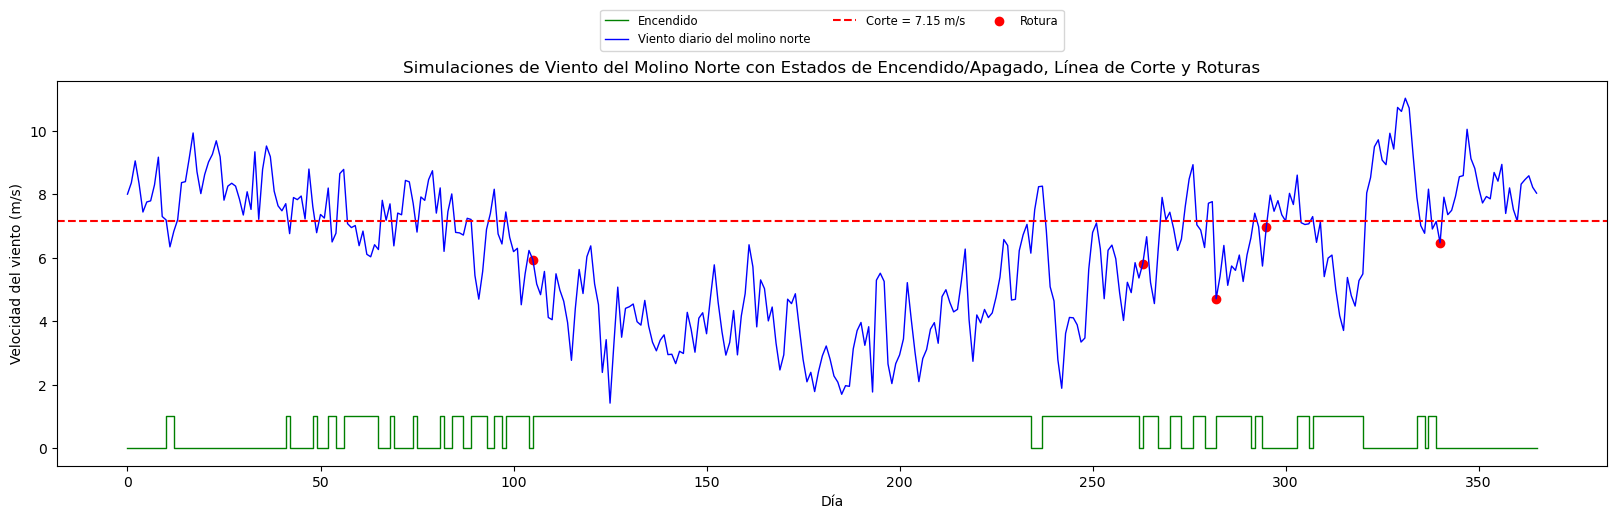

In [319]:
#Primero para el norte
corteNorte = np.sqrt(0.035/(delta * 0.25))
costo_arreglo_default = 200000
cashflowNorte, encendidosNorte, apagadosNorte, roturasNorte, simulacionNorte, van = simular_molino(datos, kappa, sigma, delta, gamma, beta, 1, corteNorte, "norte",costo_arreglo_default)
# Días del año
dias = np.arange(0, 366)

plt.figure(figsize=(20, 5))

# Graficar el estado de encendido con líneas o puntos (verde para encendido)
plt.step(dias, encendidosNorte[0], color="green", label="Encendido", where="pre", linestyle='-', linewidth=1)

# Plot de la simulación del viento encima de los gráficos de encendido/apagado
plt.plot(simulacionNorte[0], label="Viento diario del molino norte", color="blue", linewidth=1)

# Graficar la línea de corte (threshold)
plt.axhline(y=corteNorte, color='r', linestyle='--', label=f"Corte = {corteNorte:.2f} m/s")

# Añadir puntos donde hay roturas (donde roturasNorte es 1)
rotura_dias = dias[roturasNorte[0] == 1]
rotura_viento = simulacionNorte[0][roturasNorte[0] == 1]
plt.scatter(rotura_dias, rotura_viento, color="red", label="Rotura", zorder=1)


plt.title("Simulaciones de Viento del Molino Norte con Estados de Encendido/Apagado, Línea de Corte y Roturas")
plt.xlabel("Día")
plt.ylabel("Velocidad del viento (m/s)")
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=3, fontsize='small')

# Mostrar gráfico
plt.show()



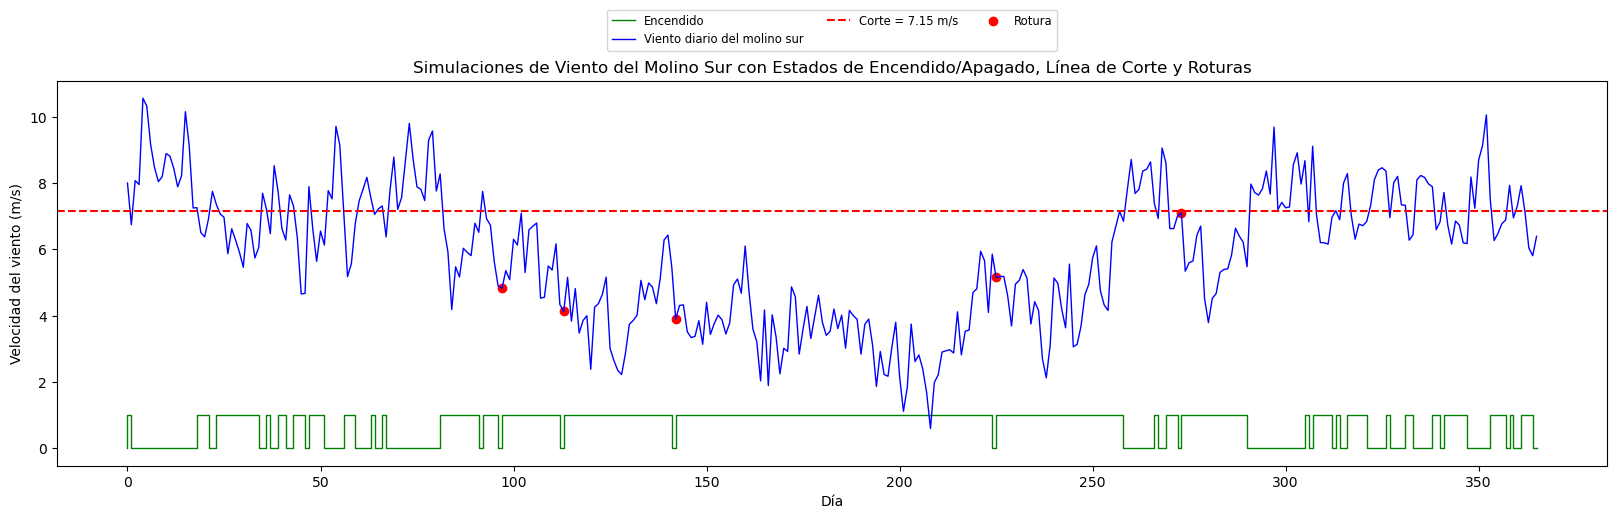

In [320]:
#Ahora para el sur
corteSur = np.sqrt(0.035/(delta * 0.25))
cashflowSur, encendidosSur, apagadosSur, roturasSur, simulacionSur,vanSur = simular_molino(datos, kappa, sigma, delta, gamma, beta, 1, corteSur, "sur",costo_arreglo_default)

# Días del año
dias = np.arange(0, 366)

plt.figure(figsize=(20, 5))

# Graficar el estado de encendido con líneas o puntos (verde para encendido)
plt.step(dias, encendidosSur[0], color="green", label="Encendido", where="pre", linestyle='-', linewidth=1)

# Plot de la simulación del viento encima de los gráficos de encendido/apagado
plt.plot(simulacionSur[0], label="Viento diario del molino sur", color="blue", linewidth=1)

# Graficar la línea de corte (threshold)
plt.axhline(y=corteSur, color='r', linestyle='--', label=f"Corte = {corteSur:.2f} m/s")

# Añadir puntos donde hay roturas (donde roturasNorte es 1)
rotura_dias = dias[roturasSur[0] == 1]
rotura_viento = simulacionSur[0][roturasSur[0] == 1]
plt.scatter(rotura_dias, rotura_viento, color="red", label="Rotura", zorder=1)


plt.title("Simulaciones de Viento del Molino Sur con Estados de Encendido/Apagado, Línea de Corte y Roturas")
plt.xlabel("Día")
plt.ylabel("Velocidad del viento (m/s)")
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=3, fontsize='small')

# Mostrar gráfico
plt.show()


El análisis realizado a partir de nuestros gráficos revela una lógica coherente en el comportamiento del molino. La línea verde, que marca los momentos en los que el molino está encendido, coincide con el cruce del umbral de viento. Cada vez que los vientos superan este límite, observamos que el molino se apaga, confirmando su correcto funcionamiento.
Además, al incluir las roturas del molino como puntos rojos en el gráfico, pudimos notar que nunca ocurren cuando el viento está por encima del umbral, lo que reafirma que el apagado preventivo funciona de manera efectiva. Incluso cuando las roturas suceden con vientos por debajo del umbral, el molino se encuentra en estado apagado, cumpliendo con los requerimientos planteados.

También a partir del gráfico vemos que ambos vientos difieren bastante por lo que probablemente los thresholds óptimos van a cambiar para cada región.

### Ejercicio 5: A partir de un número suficientemente grande de caminos calculamos el VAN esperado.
Como la función que simula el molino del ejercicio 3 ya devuelve una matriz con la van para cada simulación y día del año vamos a calcular su esperanza utilizándola. 
Consideramos que un número suficientemente grande de caminos es 10.000.
Primero vamos a calcular la VAN individual de cada molino y guardar su esperanza, además vamos a guardar una lista con los valores de cada simulación. Finalmente para calcular el total sumamos ambas esperanzas y para el desvío estándar, sumamos los valores de cada lista en una lista general y a esa le calculamos el desvío y error estándar.


In [321]:
#El van ya se calcula al simular el molino, y vamos a usar 10.000 simulaciones.
cashflowNorte10mil, encendidosNorte10mil, apagadosNorte10mil, roturasNorte10mil, simulacionNorte10mil, vanNorte10mil = simular_molino(datos,kappa,sigma,delta,gamma,beta,10000,corteNorte,"norte",costo_arreglo_default)
cashflowSur10mil, encendidosSur10mil, apagadosSur10mil, roturasSur10mil, simulacionSur10mil, vanSur10mil = simular_molino(datos,kappa,sigma,delta,gamma,beta,10000,corteSur,"sur",costo_arreglo_default)


In [322]:

# Función para calcular la esperanza del VAN para una región individual (norte o sur)
def EsperanzaVAN_individual(van):
    van_año = []
    van_esperado = 0
    for simulacion in range(len(van)):
        # Sumar el VAN de cada simulación individual
        van_esperado += van[simulacion,:].sum()
        van_año.append(van[simulacion,:].sum())
    
    # Calcular el desvío estándar y el error estándar
    
    desvio_estandar = np.std(van_año)
    error_estandar = 1.96 * (desvio_estandar / np.sqrt(len(van)))
    
    return van_esperado / len(van), desvio_estandar, error_estandar,van_año


# Función para calcular la esperanza del VAN combinado usando los resultados de las funciones individuales
def EsperanzaVANTotal(van_norte, van_sur):
    # Sumamos el VAN esperado para el norte y el sur
    vanTotal = van_norte[0] + van_sur[0]

    # Combinamos las listas de VAN de ambas regiones para calcular el desvío estándar
    lista_van_combinada=[]
    for van in range(len(van_norte[3])):
        lista_van_combinada.append(van_norte[3][van]+van_sur[3][van])
    desvio = np.std(lista_van_combinada)
    # Calculamos el error estándar a partir del desvío combinado
    error_estandar = 1.96 * (desvio / np.sqrt(len(lista_van_combinada)))
    return vanTotal, desvio, error_estandar

vanesperadoNorte=EsperanzaVAN_individual(vanNorte10mil)
vanesperadosur=EsperanzaVAN_individual(vanSur10mil)

vantotal=EsperanzaVANTotal(vanesperadoNorte,vanesperadosur)








In [323]:
print('El VAN esperado de ambos molinos es: ' + str(vantotal[0]))
print('El error estandar del valor estimado es: '+str(vantotal[2]))

El VAN esperado de ambos molinos es: 595990.5925090987
El error estandar del valor estimado es: 11728.041916441836


### Ejercicio 6: ¿Cuál es el valor óptimo para el umbral de apagado y encendido que maximice el VAN de cashflows en un año?
Vamos a probar por un rango de valores que arranquen en 0 hasta 12 (que calculamos que es el valor máximo que podría llegar a tomar el viento) y nos vamos a quedar con el que maximice el VAN para cada molin. Decidimos buscar un valor óptimo para cada molino ya que al tener vientos diferentes, seguramente necesiten distintos umbrales de corte óptimos.

In [324]:
#Probamos y vimos que siempre arriba de 0.1 el molino siempre está prendido por lo que este será nuestro valor máximo para iterar

def maximizarThreshold(datos,simulaciones,costo,molino):
    threshold=0
    mejorthreshold=0
    mejorVAN=0
    van_actual=0
    thresholds=[]
    vans=[]
    while threshold<14:
        simulacionNorte=simular_molino(datos,kappa,sigma,delta,gamma,beta,simulaciones,threshold,molino,costo)
        van_actual=EsperanzaVAN_individual(simulacionNorte[5])[0]
        if(van_actual>=mejorVAN):
            mejorVAN=van_actual
            mejorthreshold=threshold
        vans.append(van_actual)
        thresholds.append(threshold)
        threshold+=0.5
    return mejorthreshold,mejorVAN,thresholds,vans



threshold_optimo_norte=maximizarThreshold(datos,10000,costo_arreglo_default,"norte")
threshold_optimo_sur=maximizarThreshold(datos,10000,costo_arreglo_default,"sur")


print("El umbral que maximiza el VAN del molino norte es: " + str(threshold_optimo_norte[0])+" y el que maximiza el VAN del molino sur es: "+ str(threshold_optimo_sur[0]))





El umbral que maximiza el VAN del molino norte es: 7.5 y el que maximiza el VAN del molino sur es: 7.5


Vemos que este resultado tiene bastante sentido ya los thresholds obtenidos son como un "punto medio" de las velocidades del viento. Lo podremos observar mejor si hacemos graficos.

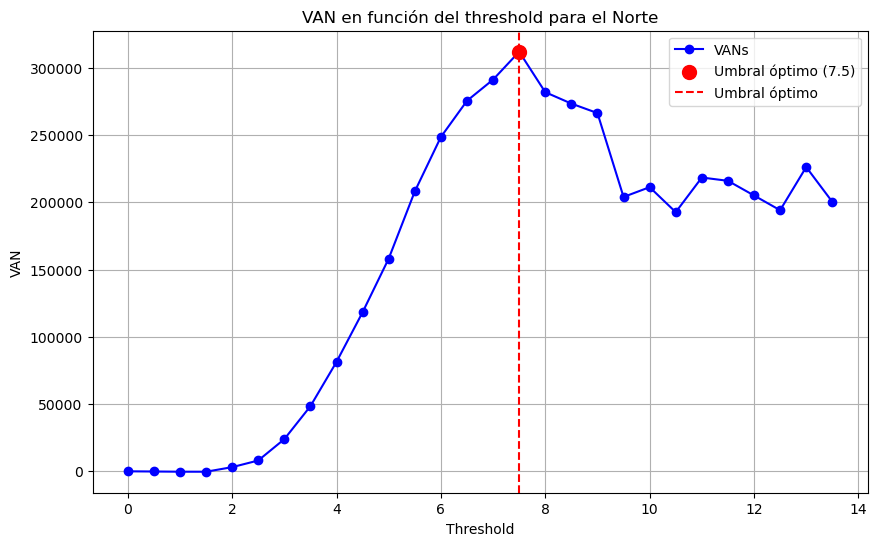

In [325]:
thresholds_norte = threshold_optimo_norte[2]
vans_norte = threshold_optimo_norte[3]
mejorthreshold_norte = threshold_optimo_norte[0]
mejorVAN_norte= threshold_optimo_norte[1]

plt.figure(figsize=(10, 6))
# Graficar todos los thresholds y VANs
plt.plot(thresholds_norte, vans_norte, marker='o', color='b', label="VANs")

# Resaltar el threshold óptimo
plt.scatter([mejorthreshold_norte], [mejorVAN_norte], color='r', zorder=5, label=f'Umbral óptimo ({mejorthreshold_norte})', s=100)

# Agregar etiquetas, título y leyenda
plt.title('VAN en función del threshold para el Norte')
plt.xlabel('Threshold')
plt.ylabel('VAN')
plt.axvline(x=mejorthreshold_norte, color='r', linestyle='--', label='Umbral óptimo')
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()


Este grafico tiene mucho sentido ya que muestra que en un inicio el VAN es bajo y va creciendo hasta que ya llega un punto donde comienza a descender. 

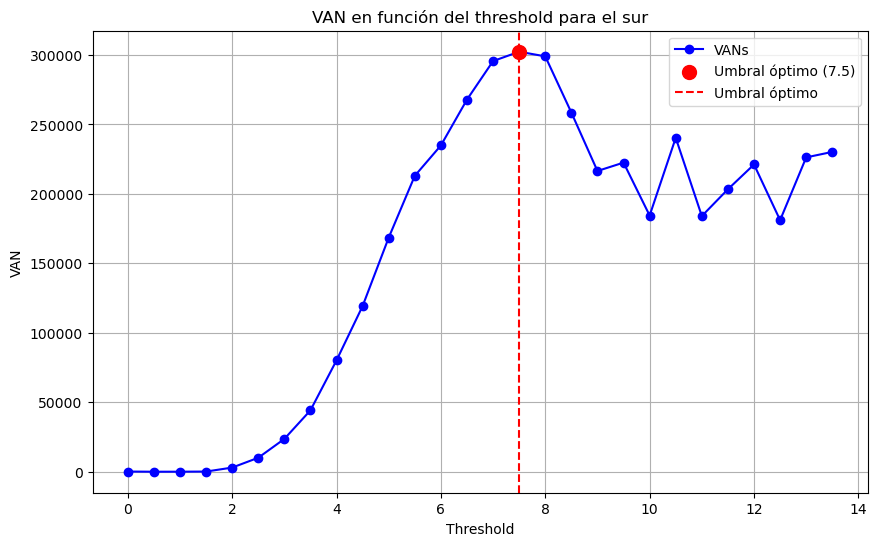

In [326]:
#Hacemos el mismo grafico para el sur.
thresholds_sur = threshold_optimo_sur[2]
vans_sur = threshold_optimo_sur[3]
mejorthreshold_sur = threshold_optimo_sur[0]
mejorVAN_sur= threshold_optimo_sur[1]

plt.figure(figsize=(10, 6))
# Graficar todos los thresholds y VANs
plt.plot(thresholds_sur, vans_sur, marker='o', color='b', label="VANs")

# Resaltar el threshold óptimo
plt.scatter([mejorthreshold_sur], [mejorVAN_sur], color='r', zorder=5, label=f'Umbral óptimo ({mejorthreshold_sur})', s=100)

# Agregar etiquetas, título y leyenda
plt.title('VAN en función del threshold para el sur')
plt.xlabel('Threshold')
plt.ylabel('VAN')
plt.axvline(x=mejorthreshold_sur, color='r', linestyle='--', label='Umbral óptimo')
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()


### Ejercicio 7: VAN sin apagar el molino vs VAN apagando los molinos óptimamente

In [327]:

#le ponemos un viento muy alto para que no se apague nunca
simulacionNorteIngenua=simular_molino(datos, kappa, sigma, delta, gamma, beta, 10000, 10000, "norte",costo_arreglo_default)
simulacionSurIngenua=simular_molino(datos, kappa, sigma, delta, gamma, beta, 10000, 10000, "sur",costo_arreglo_default)
vanNorteIngenuo=EsperanzaVAN_individual(simulacionNorteIngenua[5])
vanSurIngenuo=EsperanzaVAN_individual(simulacionSurIngenua[5])

vantotalIngenuo=EsperanzaVANTotal(vanNorteIngenuo,vanSurIngenuo)
print("El VAN para la operación ingenua que nunca apaga los molinos es: "+str(vantotalIngenuo[0]))
print('El error estandar es: '+str(vantotalIngenuo[2]))

#y ahora lo simulamos con el threshold optimizado
simulacionNorteOptimizada=simular_molino(datos,kappa,sigma,delta,gamma,beta,10000,threshold_optimo_norte[0],"norte",costo_arreglo_default)
simulacionSurOptimizada=simular_molino(datos,kappa,sigma,delta,gamma,beta,10000,threshold_optimo_sur[0],"sur",costo_arreglo_default)
vanNorteOptimizado=EsperanzaVAN_individual(simulacionNorteOptimizada[5])
vanSurOptimizado=EsperanzaVAN_individual(simulacionSurOptimizada[5])

vantotalOptimizado=EsperanzaVANTotal(vanNorteOptimizado,vanSurOptimizado)
print("El VAN para la operación que apaga los molinos optimamente: "+str(vantotalOptimizado[0]))
print('El error estandar es: '+str(vantotalOptimizado[2]))




El VAN para la operación ingenua que nunca apaga los molinos es: 397343.54180358374
El error estandar es: 16587.18761736137
El VAN para la operación que apaga los molinos optimamente: 593191.5745097245
El error estandar es: 12662.552821008438


Graficamos los promedios del van acumulado para ambas simulaciones.

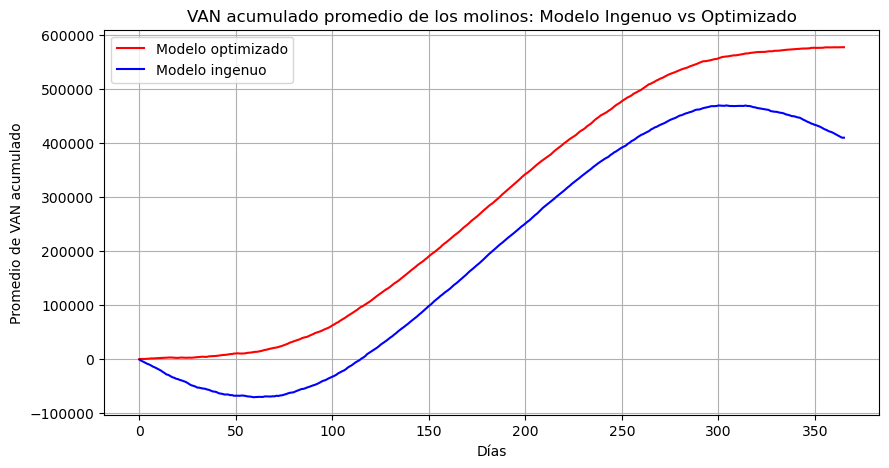

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Supongamos que estas son tus simulaciones de VAN acumulado
# Reemplaza estos datos con tus valores reales
van_esperado_dia_optimizado = []
van_esperado_dia_ingenuo = []
for dia in range(366):
    van_esperado_dia_optimizado.append(simulacionNorteOptimizada[5][:,dia].mean() + simulacionSurOptimizada[0][:,dia].mean())
    van_esperado_dia_ingenuo.append(simulacionNorteIngenua[5][:,dia].mean() + simulacionSurIngenua[0][:,dia].mean())

# Calcular las roturas acumuladas promedio día a día
van_acumulado_optimizado = np.cumsum(van_esperado_dia_optimizado)
van_acumulado_ingenua= np.cumsum(van_esperado_dia_ingenuo)

# Generar el gráfico
dias = np.arange(0, 366)  # 366 días

plt.figure(figsize=(10, 5))
plt.plot(dias, van_acumulado_optimizado, label="Modelo optimizado", color="red")
plt.plot(dias, van_acumulado_ingenua, label="Modelo ingenuo", color="blue")
plt.xlabel('Días')
plt.ylabel('Promedio de VAN acumulado')
plt.title('VAN acumulado promedio de los molinos: Modelo Ingenuo vs Optimizado')
plt.legend()
plt.grid(True)
plt.show()




Podemos observar que *siempre* es mejor apagar el molino utilizando el threshold optimo en los molinos que nunca apagarlo porque si bien aprovecha todas las velocidades del viento, es muchísimo más probable que se rompa y que pierda 200 mil dólares por cada vez que ocurre.

### Ejercicio 8: Ingreso del mes de agosto
### Nos fijamos en las acumuladas de los ingresos sin los descuentos de roturas o apagados de los molinos 


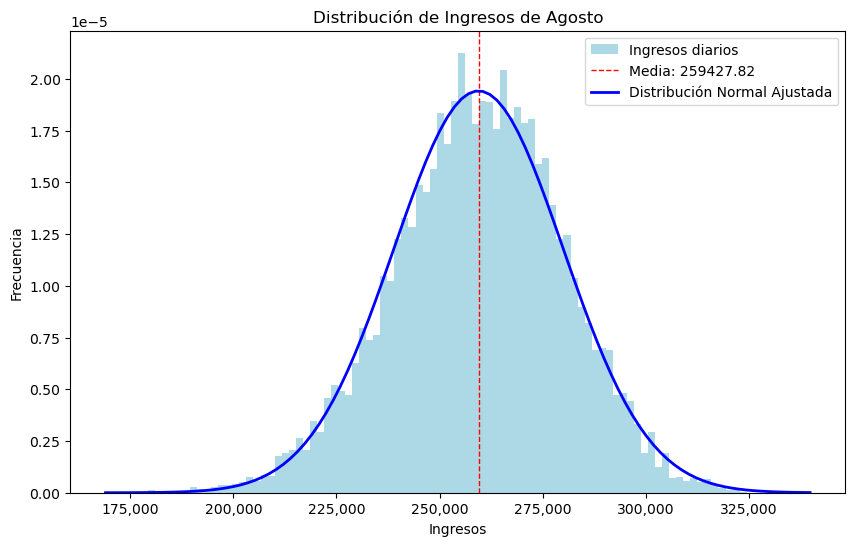

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

# Inicializamos el ingreso de agosto en cero
IngresoAgosto = 0
cashflow_agosto_grafico = []

# Sumamos los ingresos del cashflow de los días de agosto (días 213 a 243)
for simulacion in range(len(simulacionSurOptimizada[0])):
    IngresoAgosto = 0
    for dia in range(213, 244):  # Ajuste aquí para incluir el día 243
        if simulacionSurOptimizada[0][simulacion, dia] != -1000 and simulacionSurOptimizada[0][simulacion, dia] != -200000: 
            IngresoAgosto += simulacionSurOptimizada[0][simulacion, dia]
        if simulacionNorteOptimizada[0][simulacion, dia] != -1000 and simulacionNorteOptimizada[0][simulacion, dia] != -200000:
            IngresoAgosto += simulacionNorteOptimizada[0][simulacion, dia]
    cashflow_agosto_grafico.append(IngresoAgosto)


media_ingresos_agosto = np.mean(cashflow_agosto_grafico)
desvio_estandar_ingresos_agosto = np.std(cashflow_agosto_grafico)
varianza_ingresos_agosto = desvio_estandar_ingresos_agosto**2
error_estandar_ingresos_agosto = 1.96 * (desvio_estandar_ingresos_agosto / np.sqrt(len(simulacionNorteOptimizada[0])))


plt.figure(figsize=(10, 6))

# Configurar las etiquetas del eje Y para que no estén en notación científica
plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

# Histograma
plt.hist(cashflow_agosto_grafico, bins=100, color='lightblue', label='Ingresos diarios',density=True)

plt.axvline(media_ingresos_agosto, color='r', linestyle='dashed', linewidth=1, label=f'Media: {media_ingresos_agosto:.2f}')

x = np.linspace(np.min(cashflow_agosto_grafico), np.max(cashflow_agosto_grafico), 100)
y = norm.pdf(x, media_ingresos_agosto, desvio_estandar_ingresos_agosto)
plt.plot(x, y, color='blue', linestyle='-', linewidth=2, label='Distribución Normal Ajustada')

# Configurar etiquetas y título
plt.xlabel('Ingresos')
plt.ylabel('Frecuencia')
plt.title('Distribución de Ingresos de Agosto')
plt.legend()

plt.show()


Podemos ver que el gráfico tiene froma de campana, lo quenos da a entender que si tomamos los ingresos totales durante el mes de agosto como una variable aleatoria, esta tendria una distribucion aproximadamente normal. 

buscamos el desvío estandar, la media, la varianza y el error de la distribución.

In [ ]:
media_ingresos_agosto = np.mean(cashflow_agosto_grafico)
desvio_estandar_ingresos_agosto = np.std(cashflow_agosto_grafico)
varianza_ingresos_agosto = desvio_estandar_ingresos_agosto**2
error_estandar_ingresos_agosto = 1.96 * (desvio_estandar_ingresos_agosto / np.sqrt(len(simulacionNorteOptimizada[0])))

print("la media de los ingresos de agosto es: ", media_ingresos_agosto, "dólares")
print("el desvío estandar de los ingresos de agosto es: ", desvio_estandar_ingresos_agosto, "dólares")
print("el error estandar de los ingresos de agosto es: ", error_estandar_ingresos_agosto, "dólares")
print("la varianza de los ingresos de agosto es: ", varianza_ingresos_agosto, "dólares")



la media de los ingresos de agosto es:  259427.8172289339 dólares
el desvío estandar de los ingresos de agosto es:  20546.522269136316 dólares
el error estandar de los ingresos de agosto es:  402.7118364750718 dólares
la varianza de los ingresos de agosto es:  422159577.35611457 dólares


### Ejercicio 9: numero promedio de Roturas no apagando nunca los molinos vs apagandolos optimamente

In [ ]:
#para sacar el numero medio de roturas hay que sacar la media de todas las simulaciones

def media_roturas(roturas):
    cantidad_rotos=0
    rotos=[]
    for simulacion in range(len(roturas)):
        rotos.append(roturas[simulacion].sum())
        cantidad_rotos+=roturas[simulacion].sum()
    desvio=np.std(rotos)
    error_estandar= 1.96 * (desvio / np.sqrt(len(roturas)))
    return round(cantidad_rotos/len(roturas)), desvio, error_estandar

In [ ]:
mediaRoturasNorteIngenua=media_roturas(simulacionNorteIngenua[3])    
mediaRoturasSurIngenua=media_roturas(simulacionSurIngenua[3])  
mediaRoturasNorte=media_roturas(simulacionNorteOptimizada[3])    
mediaRoturasSur=media_roturas(simulacionSurOptimizada[3])      
        


print("El numero medio de roturas por año en el modelo ingenuo del norte es: "+str(mediaRoturasNorteIngenua[0]))
#print('El error estandar de esta medicion es: '+ str(mediaRoturasNorteIngenua[2]))

print("El numero medio de roturas que sufre apagando el modelo de manera optima del norte es: "+str(mediaRoturasNorte[0]))
#print('El error estandar de esta medicion es: '+ str(mediaRoturasSurIngenua[2]))

print("El numero medio de roturas por año en el modelo ingenuo del Sur es: "+str(mediaRoturasSurIngenua[0]))
#print('El error estandar de esta medicion es: '+ str(mediaRoturasNorte[2]))

print("El numero medio de roturas que sufre apagando el modelo de manera optima del Sur es: "+str(mediaRoturasSur[0]))
#print('El error estandar de esta medicion es: '+ str(mediaRoturasNorte[2]))

El numero medio de roturas por año en el modelo ingenuo del norte es: 10
El numero medio de roturas que sufre apagando el modelo de manera optima del norte es: 6
El numero medio de roturas por año en el modelo ingenuo del Sur es: 10
El numero medio de roturas que sufre apagando el modelo de manera optima del Sur es: 3


Los resultados concuerdan con lo que intuiamos: apagar el molino optimamente reduce mucho la cantidad de veces que estos se rompen.

Finalmente, hicimos unos gráficos que muestran la evolución de la suma del promedio de roturas acumuladas a lo largo del año en ambos molinos optimizados e ingenuos

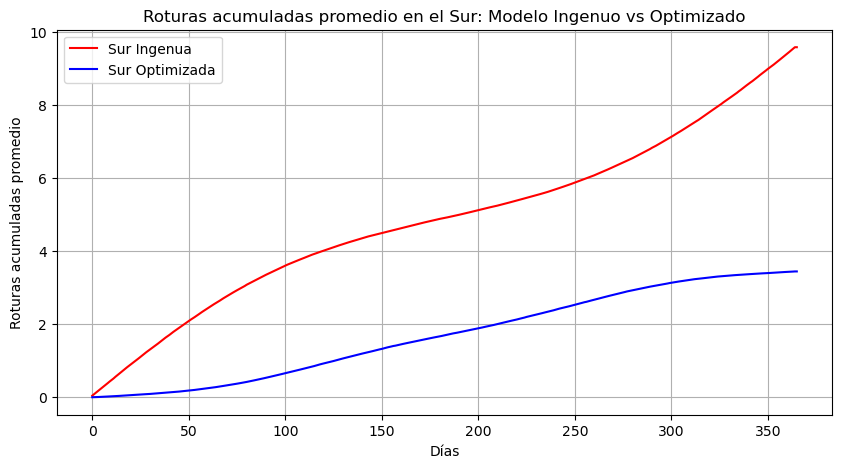

(10, 2.9662930384572594, 0.05813934355376228)
(3, 1.8325597370890805, 0.03591817084694597)


In [ ]:
roturas_sur_grafico_ingenua = simulacionSurIngenua[3]
roturas_sur_grafico_optimizado = simulacionSurOptimizada[3]

# Calcular la media diaria de roturas a lo largo de todas las simulaciones
media_dia_sur_ingenua = roturas_sur_grafico_ingenua.mean(axis=0)
media_dia_sur_optimizado = roturas_sur_grafico_optimizado.mean(axis=0)

# Calcular las roturas acumuladas promedio día a día
roturas_acumuladas_sur_ingenua = np.cumsum(media_dia_sur_ingenua)
roturas_acumuladas_sur_optimizado = np.cumsum(media_dia_sur_optimizado)

# Generar el gráfico
dias = np.arange(0, 366)  # 365 días
plt.figure(figsize=(10, 5))
plt.plot(dias, roturas_acumuladas_sur_ingenua, label="Sur Ingenua", color="red")
plt.plot(dias, roturas_acumuladas_sur_optimizado, label="Sur Optimizada", color="blue")
plt.xlabel('Días')
plt.ylabel('Roturas acumuladas promedio')
plt.title('Roturas acumuladas promedio en el Sur: Modelo Ingenuo vs Optimizado')
plt.legend()
plt.grid(True)
plt.show()
roturas_norte_grafico_ingenua = simulacionNorteIngenua[3]
roturas_norte_grafico_optimizado = simulacionNorteOptimizada[3]

# Calcular la media diaria de roturas a lo largo de todas las simulaciones
media_dia_norte_ingenua = roturas_norte_grafico_ingenua.mean(axis=0)
media_dia_norte_optimizado = roturas_norte_grafico_optimizado.mean(axis=0)

#Acá imprimimos las roturas promedio de ambas simulaciones junto con su desvío y error estandar
print(media_roturas(roturas_sur_grafico_ingenua))
print(media_roturas(roturas_sur_grafico_optimizado))


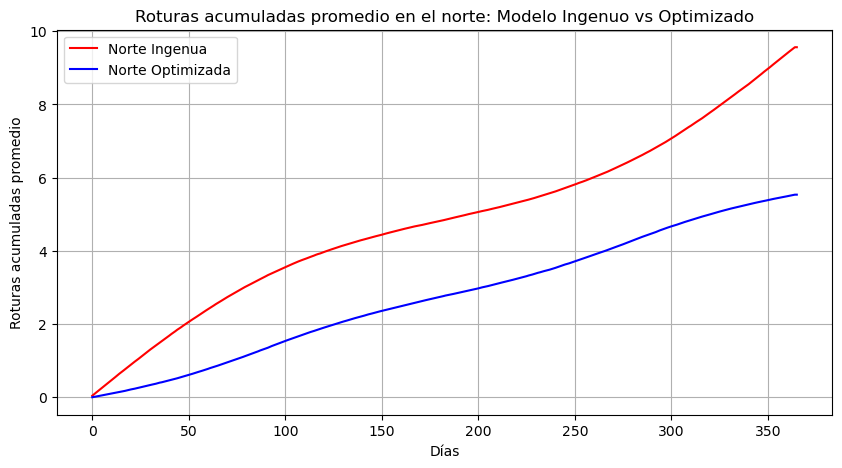

(10, 2.9757017592494046, 0.058323754481288334)
(6, 2.292627259281369, 0.04493549428191483)


In [ ]:
roturas_norte_grafico_ingenua = simulacionNorteIngenua[3]
roturas_norte_grafico_optimizado = simulacionNorteOptimizada[3]

# Calcular la media diaria de roturas a lo largo de todas las simulaciones
media_dia_norte_ingenua = roturas_norte_grafico_ingenua.mean(axis=0)
media_dia_norte_optimizado = roturas_norte_grafico_optimizado.mean(axis=0)

# Calcular las roturas acumuladas promedio día a día
roturas_acumuladas_norte_ingenua = np.cumsum(media_dia_norte_ingenua)
roturas_acumuladas_norte_optimizado = np.cumsum(media_dia_norte_optimizado)

# Generar el gráfico
dias = np.arange(0, 366)  # 366 días

plt.figure(figsize=(10, 5))
plt.plot(dias, roturas_acumuladas_norte_ingenua, label="Norte Ingenua", color="red")
plt.plot(dias, roturas_acumuladas_norte_optimizado, label="Norte Optimizada", color="blue")
plt.xlabel('Días')
plt.ylabel('Roturas acumuladas promedio')
plt.title('Roturas acumuladas promedio en el norte: Modelo Ingenuo vs Optimizado')
plt.legend()
plt.grid(True)
plt.show()


#Acá imprimimos las roturas promedio de ambas simulaciones
print(media_roturas(roturas_norte_grafico_ingenua))
print(media_roturas(roturas_norte_grafico_optimizado))

Finalmente, pudimos observar que, a lo largo del año, si bien las simulaciones cambian cada vez que las generamos, siempre se mantiene el modelo optimizado con un promedio de roturas considerablemente menor que el del ingenuo. Esto tiene sentido ya que, el tener un umbral, si bien genera que no pierda dinero al apagar el molino, el apagar el mismo también me evita el riesgo de roturas cuyo precio es considerablemente más alto que el de apagar el molino y que cualquier ganancia generada por los vientos de 1 día. 

### Ejercicio 10: número promedio de días en el que el molino se encuentra apagado bajo la estrategia óptima


In [ ]:
def estimacion_apagados_molino(apagados):
    cantidad_apagados=0
    apagados_por_simulacion = []
    for simulacion in range(len(apagados)):
        cantidad_apagados+=apagados[simulacion].sum()
        apagados_por_simulacion.append(apagados[simulacion].sum())
    desvio_estandar = np.std(apagados_por_simulacion)
    error_estandar = 1.96*(desvio_estandar/np.sqrt(len(apagados)))
    return cantidad_apagados/len(apagados), desvio_estandar, error_estandar

estimacionApagadosNorte=estimacion_apagados_molino(simulacionNorteOptimizada[2])
estimacionApagadosSur=estimacion_apagados_molino(simulacionSurOptimizada[2])



print("El molino Norte (bajo la estrategia óptima) está apagado un promedio de: ",estimacionApagadosNorte[0], "dias, esta estimación tiene un error estandar de: ", estimacionApagadosNorte[2], "y un desvío de", estimacionApagadosNorte[1])

print("El molino Sur (bajo la estrategia óptima) está apagado un promedio de: ",estimacionApagadosSur[0], "dias, esta estimación tiene un error estandar de: ", estimacionApagadosSur[2], "y un desvío de", estimacionApagadosSur[1])


El molino Norte (bajo la estrategia óptima) está apagado un promedio de:  91.2875 dias, esta estimación tiene un error estandar de:  0.27658568577386644 y un desvío de 14.111514580299309
El molino Sur (bajo la estrategia óptima) está apagado un promedio de:  152.4735 dias, esta estimación tiene un error estandar de:  0.2945263101042757 y un desvío de 15.026852556340598


Tiene sentido que al definir un umbral que apaga más seguido el molino, va a pasar más días apagados.

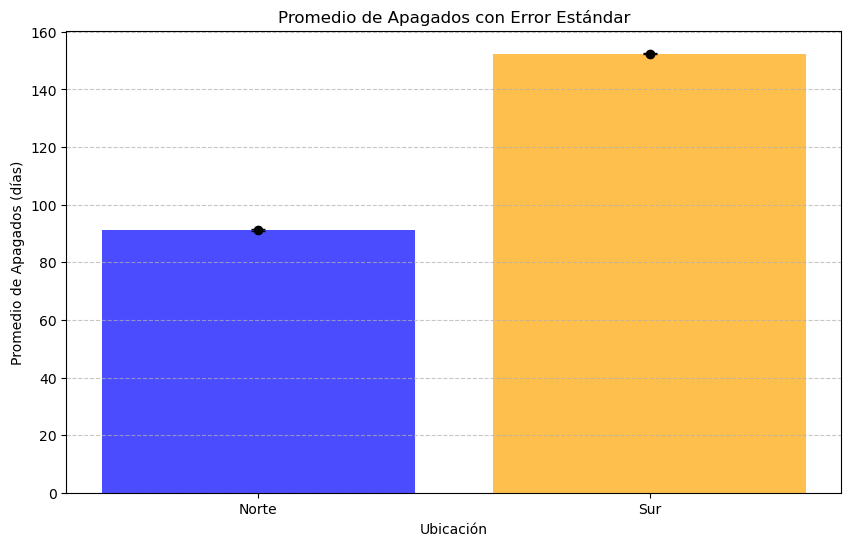

In [ ]:

# Datos
categorias = ['Norte', 'Sur']
medias = [estimacionApagadosNorte[0], estimacionApagadosSur[0]]
errores = [estimacionApagadosNorte[2], estimacionApagadosSur[2]]

# Configuración del gráfico
plt.figure(figsize=(10, 6))
plt.bar(categorias, medias, color=['blue', 'orange'], alpha=0.7)
plt.errorbar(categorias, medias, yerr=errores, fmt='o', color='black', capsize=5)
plt.xlabel('Ubicación')
plt.ylabel('Promedio de Apagados (días)')
plt.title('Promedio de Apagados con Error Estándar')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


En general, el molino sur se mantiene más días apagado que el molino norte, esto se puede deber a que tiene vientos más altos. 

### Ejercicio 11.a: Probabilidad de que los dos molinos estén inactivos el 9 de julio.

Para calcular la probabilidad de que ambos molinos estén apagados el 9 de julio, es decir, el día 190 (o 189 si contabilizamos los días desde 0) de nuestro modelo, lo que hicimos fue contabilizar la cantidad de caminos de la simulación en la que ambos molinos se encontraban apagados ese día y luego dividirlo en la cantidad de casos totales, es decir, la cantidad de caminos.

## Fórmula

A su vez, como es una estimación, le calculamos el error con la fórmula de 

$$
\hat{P} = \frac{1}{M} \sum_{j=1}^{M} \mathbf{1}\left\{\text{apagado\_sur}[dia_i][j] \text{ y } \text{apagado\_norte}[dia_i][j] == 1 \right\}
$$
El error de estimación es proporcional a:

$$
\sqrt{\hat{P} - \hat{P}^2}
$$


In [340]:
# Funciones ya definidas (las que mencionas en tu código)
def error_de_estimacion_proba(P): 
    return np.sqrt(P - (P**2))

def estimarProbaApagado_i(dia, apagadosNorte, apagadosSur):
    apagados = 0
    for simulacion in range(len(apagadosNorte)):
        if apagadosNorte[simulacion, dia] == 1 and apagadosSur[simulacion, dia] == 1:
            apagados += 1
    return apagados / len(apagadosNorte)


# Probabilidad estimada y error ya calculados
probaApagado9julio = estimarProbaApagado_i(189, simulacionNorteOptimizada[2], simulacionSurOptimizada[2])
error = error_de_estimacion_proba(probaApagado9julio)


In [374]:
# Crear el gráfico de puntos con barra de error

probas_apagados_9julio = []
errores_probabilidades = []
for i in range(10): 
    simulacionNorteOptimizada=simular_molino(datos,kappa,sigma,delta,gamma,beta,10000,threshold_optimo_norte[0],"norte",costo_arreglo_default)
    simulacionSurOptimizada=simular_molino(datos,kappa,sigma,delta,gamma,beta,10000,threshold_optimo_sur[0],"sur",200000)
    totales_norte_mayo = np.sum(simulacionNorteOptimizada[0][:, 120:151], axis=1)
    totales_sur_mayo = np.sum(simulacionSurOptimizada[0][:, 120:151], axis=1)
    probaApagado9julio = estimarProbaApagado_i(189, simulacionNorteOptimizada[2], simulacionSurOptimizada[2])
    probas_apagados_9julio.append(probaApagado9julio)
    error_probas = error_de_estimacion_proba(probaApagado9julio)
    errores_probabilidades.append(error_probas)

    print(f'La probabilidad de ambos apagados el 9 de julio es de: {probaApagado9julio}')
print(probas_apagados_9julio)



La probabilidad de ambos apagados el 9 de julio es de: 0.0001
La probabilidad de ambos apagados el 9 de julio es de: 0.0001
La probabilidad de ambos apagados el 9 de julio es de: 0.0
La probabilidad de ambos apagados el 9 de julio es de: 0.0003
La probabilidad de ambos apagados el 9 de julio es de: 0.0003
La probabilidad de ambos apagados el 9 de julio es de: 0.0002
La probabilidad de ambos apagados el 9 de julio es de: 0.0002
La probabilidad de ambos apagados el 9 de julio es de: 0.0004
La probabilidad de ambos apagados el 9 de julio es de: 0.0001
La probabilidad de ambos apagados el 9 de julio es de: 0.0002
[0.0001, 0.0001, 0.0, 0.0003, 0.0003, 0.0002, 0.0002, 0.0004, 0.0001, 0.0002]


Graficamos nuestros resultados 

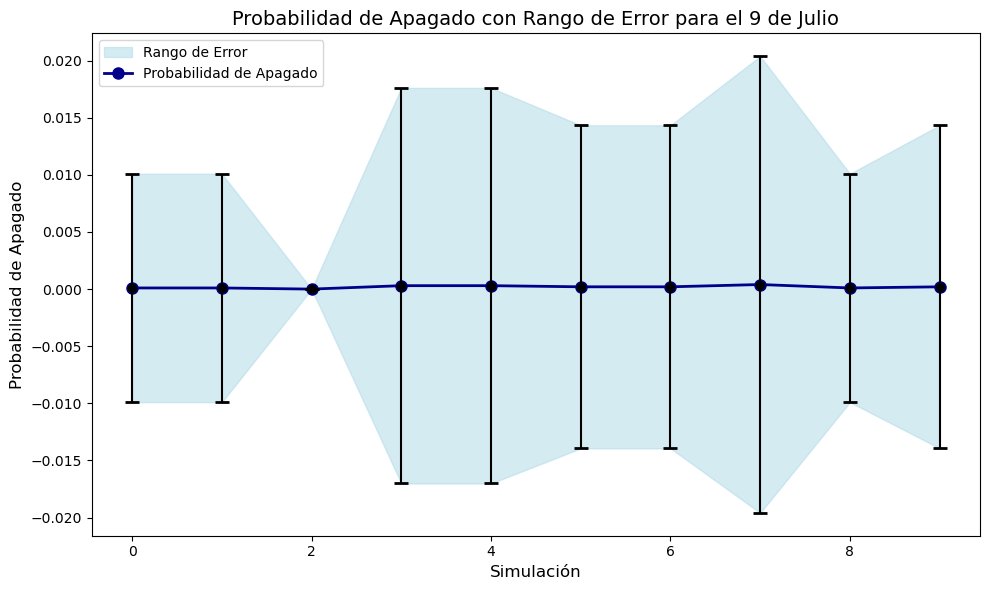

In [390]:
# Crear el gráfico de área
plt.figure(figsize=(10, 6))

# Área
x = np.arange(len(probas_apagados_9julio))
plt.fill_between(x, 
                 np.array(probas_apagados_9julio) - np.array(errores_probabilidades), 
                 np.array(probas_apagados_9julio) + np.array(errores_probabilidades), 
                 color='lightblue', alpha=0.5, label='Rango de Error')

# Línea y puntos
plt.plot(x, probas_apagados_9julio, color='darkblue', marker='o', linestyle='-', linewidth=2, markersize=8, label='Probabilidad de Apagado')
plt.errorbar(x, probas_apagados_9julio, yerr=errores_probabilidades, fmt='o', color='black', capsize=5, capthick=2)

# Etiquetas y título
plt.xlabel('Simulación', fontsize=12)
plt.ylabel('Probabilidad de Apagado', fontsize=12)
plt.title('Probabilidad de Apagado con Rango de Error para el 9 de Julio', fontsize=14)
plt.legend(loc='upper left')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

### Ejercicio 11.b: Probabilidad de que los dos molinos estén inactivos algún día del año.

In [342]:
# Calcular la probabilidad de que ambos molinos estén apagados el mismo día
def estimar_proba_dias(apagadosNorte, apagadosSur):
    apagados = 0
    total_dias = len(apagadosNorte) * len(apagadosNorte[0])  # Total de días en todas las simulaciones
    for simulacion in range(len(apagadosNorte)): #Para todas las simulaciones
        for dia in range(366):  # Para cada día del año
            if apagadosNorte[simulacion, dia] == 1 and apagadosSur[simulacion, dia] == 1:
                apagados += 1
    # Dividir por el total de días en todas las simulaciones
    return apagados / total_dias
probaApagadoalgundia = estimar_proba_dias(simulacionNorteOptimizada[2], simulacionSurOptimizada[2])
print(f"La probabilidad de que los dos molinos estén inactivos algún día del año es: {probaApagadoalgundia:.4f}")
#calculamos el error de la estimación 
error_ambos_apagados = error_de_estimacion_proba(probaApagadoalgundia)
print("el error de la estimación es de:", error_ambos_apagados) # poner en porcentaje??????


La probabilidad de que los dos molinos estén inactivos algún día del año es: 0.1212
el error de la estimación es de: 0.32633291579654705


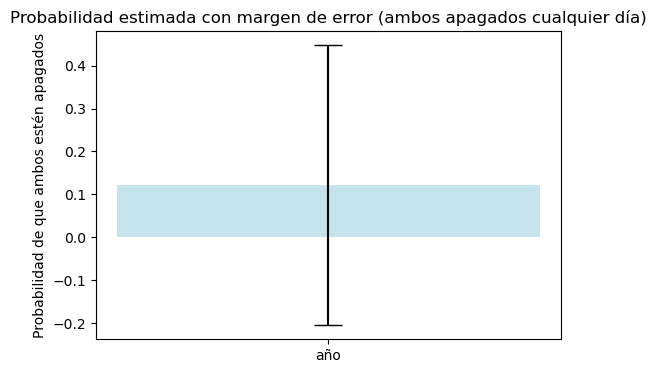

La probabilidad de que los dos molinos estén inactivos el  es: 12.12%
El error de la estimación es de: 2.00%


In [351]:

# Graficar la probabilidad con barra de error
plt.figure(figsize=(6,4))
plt.bar(['año'], [probaApagadoalgundia], yerr=[error_ambos_apagados], color='lightblue', alpha=0.7, capsize=10)

# Etiquetas y título
plt.ylabel('Probabilidad de que ambos estén apagados')
plt.title('Probabilidad estimada con margen de error (ambos apagados cualquier día)')

# Mostrar gráfico
plt.show()

# Mostrar la probabilidad y el error en porcentaje
print(f"La probabilidad de que los dos molinos estén inactivos el  es: {probaApagadoalgundia*100:.2f}%")
print(f"El error de la estimación es de: {error*100:.2f}%")

### Ejercicio 12: Correlación entre los ingresos mensuales de mayo de los 2 molinos

Depende de la simulación, pero la correlación es muy pequeña

In [ ]:

# Sumar los cashflows de mayo (días 120 al 150) para cada simulación y creamos una lista con las mismas
totales_norte_mayo = np.sum(simulacionNorteOptimizada[0][:, 120:151], axis=1)
totales_sur_mayo = np.sum(simulacionSurOptimizada[0][:, 120:151], axis=1)
# Calcular la correlación
correlacion = np.corrcoef(totales_norte_mayo, totales_sur_mayo)[0, 1]

print(f'La correlación entre los ingresos totales de mayo del molino norte y sur es: {correlacion}')




La correlación entre los ingresos totales de mayo del molino norte y sur es: -0.0225002505501518


In [333]:
correlaciones_mayo_norte_sur = []
for i in range(10): 
    simulacionNorteOptimizada=simular_molino(datos,kappa,sigma,delta,gamma,beta,10000,threshold_optimo_norte[0],"norte",costo_arreglo_default)
    simulacionSurOptimizada=simular_molino(datos,kappa,sigma,delta,gamma,beta,10000,threshold_optimo_sur[0],"sur",200000)
    totales_norte_mayo = np.sum(simulacionNorteOptimizada[0][:, 120:151], axis=1)
    totales_sur_mayo = np.sum(simulacionSurOptimizada[0][:, 120:151], axis=1)
    # Calcular la correlación
    correlacion = np.corrcoef(totales_norte_mayo, totales_sur_mayo)[0, 1]
    correlaciones_mayo_norte_sur.append(correlacion)
    print(f'La correlación entre los ingresos totales de mayo del molino norte y sur es: {correlacion}')
print(correlaciones_mayo_norte_sur)

La correlación entre los ingresos totales de mayo del molino norte y sur es: -0.006010776565192842
La correlación entre los ingresos totales de mayo del molino norte y sur es: -0.001828582074865811
La correlación entre los ingresos totales de mayo del molino norte y sur es: -0.0019471325507386893
La correlación entre los ingresos totales de mayo del molino norte y sur es: 0.02800250071376154
La correlación entre los ingresos totales de mayo del molino norte y sur es: -0.0076626090479179785
La correlación entre los ingresos totales de mayo del molino norte y sur es: 0.012515799586321237
La correlación entre los ingresos totales de mayo del molino norte y sur es: -0.0009787513382711
La correlación entre los ingresos totales de mayo del molino norte y sur es: 0.005640628802402013
La correlación entre los ingresos totales de mayo del molino norte y sur es: 0.0022938925972367684
La correlación entre los ingresos totales de mayo del molino norte y sur es: -0.01751460944407118
[-0.00601077656

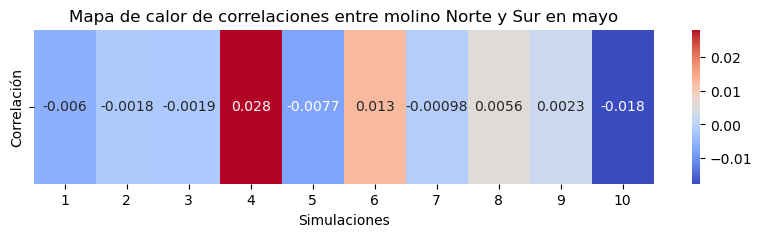

In [334]:

# Convertir la lista de correlaciones a una matriz de calor (reshape)
correlaciones_matrix = np.array(correlaciones_mayo_norte_sur).reshape(1, -1)  # 1 fila, N columnas

# Crear el mapa de calor
plt.figure(figsize=(10, 2))  # Ajustar el tamaño para una fila
sns.heatmap(correlaciones_matrix, annot=True, cmap="coolwarm", cbar=True, xticklabels=np.arange(1, len(correlaciones_mayo_norte_sur)+1), yticklabels=["Correlación"])

# Etiquetas y título
plt.title('Mapa de calor de correlaciones entre molino Norte y Sur en mayo')
plt.xlabel('Simulaciones')

# Mostrar gráfico
plt.show()


### Ejercicio 13: Sensibilidad del VAN al costo del arreglo de los molinos. 


Calculamos la sensibilidad (en términos de unidad de dólar) con la fórmula de la derivada: 
$$
\frac{
    \frac{1}{M} \sum_{j=1}^{M} f(\alpha + \epsilon, S_T^j) - \frac{1}{M} \sum_{j=1}^{M} f(\alpha - \epsilon, S_T^j)
}{
    2 \epsilon
}
$$
Calcula en cuanto varía mi VAN en unidad de dólar a medida que aumento el costo del arreglo. 

In [393]:
diferencia_costo_de_arreglo = 50000
simulacion_sensibilidad_norte_menor_arreglo = simular_molino(datos,kappa,sigma,delta,gamma,beta,1000,threshold_optimo_norte[0],"norte",200000-diferencia_costo_de_arreglo)
simulacion_sensibilidad_norte_mayor_arreglo = simular_molino(datos,kappa,sigma,delta,gamma,beta,1000,threshold_optimo_norte[0],"norte",200000+diferencia_costo_de_arreglo)

esperanza_norte_menor_arreglo = EsperanzaVAN_individual(simulacion_sensibilidad_norte_menor_arreglo[5])
esperanza_norte_mayor_arreglo =EsperanzaVAN_individual(simulacion_sensibilidad_norte_mayor_arreglo[5])

simulacion_sensibilidad_sur_menor_arreglo = simular_molino(datos,kappa,sigma,delta,gamma,beta,1000,threshold_optimo_sur[0],"sur",200000-diferencia_costo_de_arreglo)
simulacion_sensibilidad_sur_mayor_arreglo = simular_molino(datos,kappa,sigma,delta,gamma,beta,1000,threshold_optimo_norte[0],"sur",200000+diferencia_costo_de_arreglo)

esperanza_sur_menor_arreglo = EsperanzaVAN_individual(simulacion_sensibilidad_sur_menor_arreglo[5])
esperanza_sur_mayor_arreglo =EsperanzaVAN_individual(simulacion_sensibilidad_sur_mayor_arreglo[5])


esperanza_van_menor_arreglo = EsperanzaVANTotal(esperanza_sur_menor_arreglo,esperanza_norte_menor_arreglo)
esperanza_van_mayor_arreglo = EsperanzaVANTotal(esperanza_norte_mayor_arreglo, esperanza_sur_mayor_arreglo)

sensibilidad_costo_arreglo = (esperanza_van_mayor_arreglo[0] - esperanza_van_menor_arreglo[0])/(2*diferencia_costo_de_arreglo)
print("La sensibilidad del Van al costo de arreglo de roturas: " +str(sensibilidad_costo_arreglo), "lo que significa que por cada dólar que subo el costo de arreglo el van disminuye en ", abs(sensibilidad_costo_arreglo), "dólares" )

# Calculamos el promedio del van para los camino

La sensibilidad del Van al costo de arreglo de roturas: -10.645501213033986 lo que significa que por cada dólar que subo el costo de arreglo el van disminuye en  10.645501213033986 dólares


Si bien, el valor de sensibilidad cambia debido a que las simulaciones varían, notamos que el resultado es siempre negativo, lo cual indica que a más costo de arreglo más dólares del VAN pierdo. Graficamos para verlo mejor:

In [404]:
# Lista de diferentes costos de arreglo
variacion_de_costos = [100000, 150000, 200000, 250000]
van = []
van_esperado = []

# Simulamos el molino para cada costo de arreglo y guardamos los resultados de VAN
for costo in variacion_de_costos:
    simulacion_n = simular_molino(datos, kappa, sigma, delta, gamma, beta, 10000, threshold_optimo_norte[0], "norte", costo)
    simulacion_s = simular_molino(datos, kappa, sigma, delta, gamma, beta, 10000, threshold_optimo_sur[0], "sur", costo)
    
    van_norte=EsperanzaVAN_individual(simulacion_n[5])
    van_sur=EsperanzaVAN_individual(simulacion_s[5])
    van.append(simulacion_n[5][:,:] + simulacion_s[5][:,:])
    van_esperado.append(EsperanzaVANTotal(van_norte,van_sur)[0])

# Ahora, calculamos el VAN promedio por día para cada costo
VAN_norte_acumulado_por_costo = []

for van_simulacion in van:
    VAN_total = []
    VANTotal = 0
    # Acumular el VAN día a día a lo largo del año
    for dia in range(0, 366):
        VANTotal += van_simulacion[:, dia].mean()  # Promedio de todas las simulaciones en ese día
        VAN_total.append(VANTotal)
    VAN_norte_acumulado_por_costo.append(VAN_total)  # Guardamos el VAN acumulado para cada costo



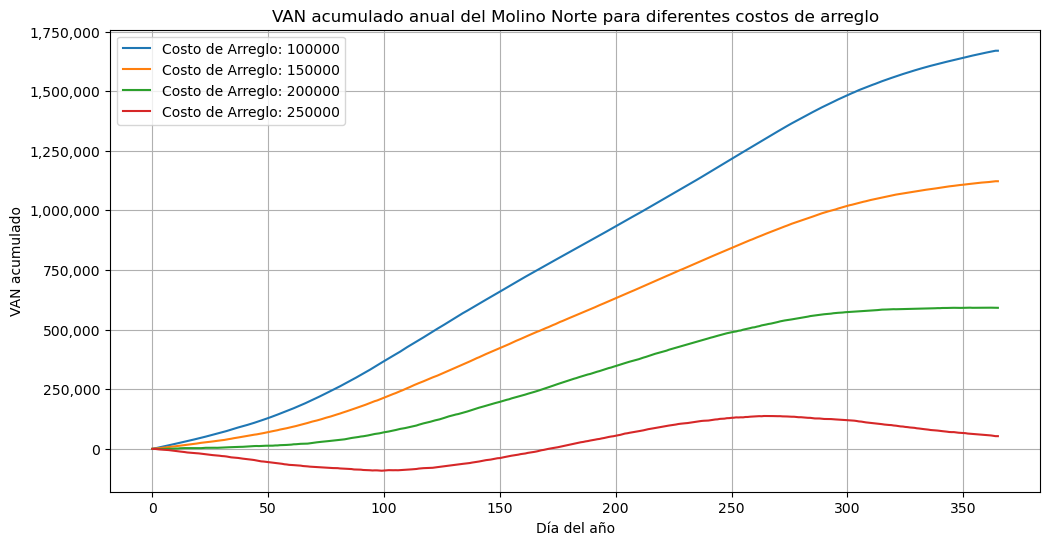

In [406]:
# Graficamos el VAN acumulado para cada costo
plt.figure(figsize=(12, 6))
dias = np.arange(0, 366)

# Recorremos los costos y sus VANs acumulados para graficar
for i, costo in enumerate(variacion_de_costos):
    plt.plot(dias, VAN_norte_acumulado_por_costo[i], label=f"Costo de Arreglo: {costo}")

simulacionNorteOptimizada[5][:,dia].mean() + simulacionSurOptimizada[0][:,dia].mean()
# Añadir títulos y leyenda
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.title("VAN acumulado anual del Molino Norte para diferentes costos de arreglo")
plt.xlabel("Día del año")
plt.ylabel("VAN acumulado")
plt.legend()

# Mostrar gráfico
plt.grid(True)
plt.show()

Graficamos distintas funciones del VAN promedio acumulado para ver cómo varía con el costo de arreglo 

In [397]:
#def simular_molino(datos, kappa, sigma, delta, gamma, beta, simulaciones, K, molino,arreglo)



umbral_optimo250=maximizarThreshold(datos,10000,250000,"norte")

umbral_optimo150=maximizarThreshold(datos,10000,150000,"norte")

print("El umbral óptimo para el norte con costo $150.000 es: "+ str(umbral_optimo150[0]))

print("El umbral óptimo para el norte con costo $200.000 es: "+ str(threshold_optimo_norte[0]))

print("El umbral óptimo para el norte con costo $250.000 es: "+ str(umbral_optimo250[0]))




El umbral óptimo para el norte con costo $150.000 es: 13.0
El umbral óptimo para el norte con costo $200.000 es: 7.5
El umbral óptimo para el norte con costo $250.000 es: 6.0


Tiene sentido que a medida que se incremente el costo de arreglar el molino, cada vez quiera evitar que se rompa más, por lo que va a ir subiendo el threshold.

Vamos a graficar un camino del viento para cada threshold así evaluamos mejor su comportamiento.

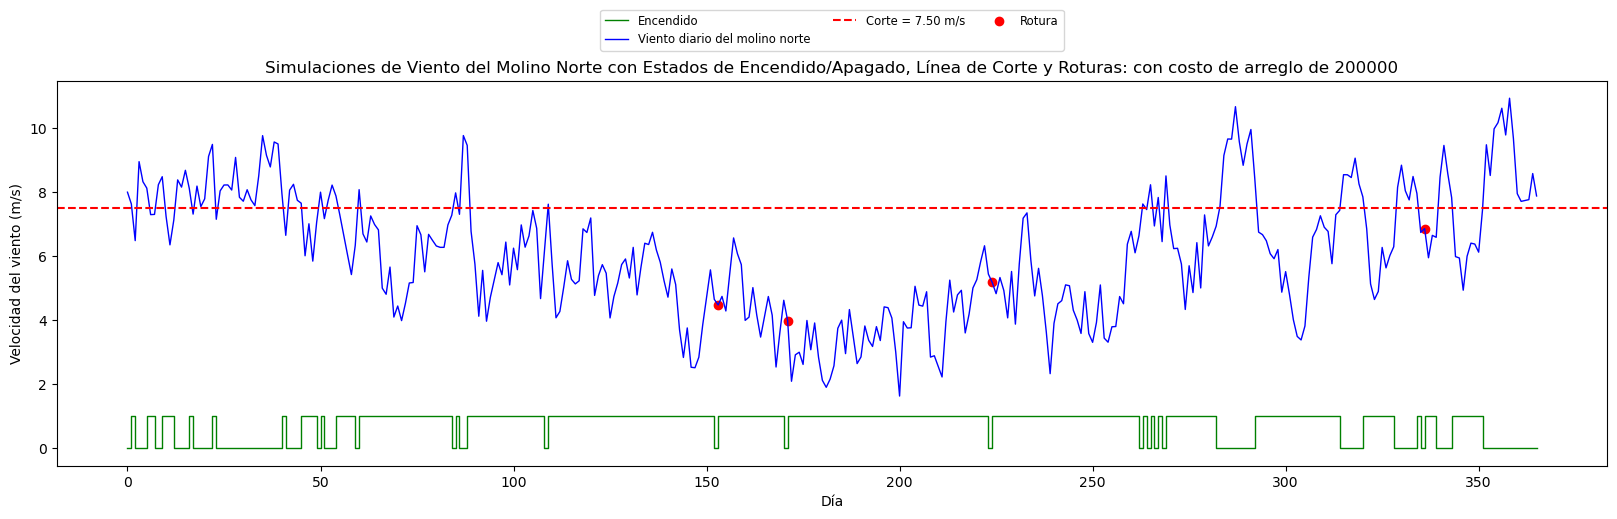

In [398]:
costo_arreglo_default = 200000
cashflowNorte, encendidosNorte, apagadosNorte, roturasNorte_200, simulacionNorte, van_200 = simular_molino(datos, kappa, sigma, delta, gamma, beta, 1, threshold_optimo_norte[0], "norte",costo_arreglo_default)
# Días del año
dias = np.arange(0, 366)

plt.figure(figsize=(20, 5))

# Graficar el estado de encendido con líneas o puntos (verde para encendido)
plt.step(dias, encendidosNorte[0], color="green", label="Encendido", where="pre", linestyle='-', linewidth=1)

# Plot de la simulación del viento encima de los gráficos de encendido/apagado
plt.plot(simulacionNorte[0], label="Viento diario del molino norte", color="blue", linewidth=1)

# Graficar la línea de corte (umbral)
plt.axhline(y=threshold_optimo_norte[0], color='r', linestyle='--', label=f"Corte = {threshold_optimo_norte[0]:.2f} m/s")

# Añadir puntos donde hay roturas (donde roturasNorte es 1)
rotura_dias = dias[roturasNorte_200[0] == 1]
rotura_viento = simulacionNorte[0][roturasNorte_200[0] == 1]
plt.scatter(rotura_dias, rotura_viento, color="red", label="Rotura", zorder=1)

# Añadir títulos y leyenda
plt.title("Simulaciones de Viento del Molino Norte con Estados de Encendido/Apagado, Línea de Corte y Roturas: con costo de arreglo de 200000")
plt.xlabel("Día")
plt.ylabel("Velocidad del viento (m/s)")
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=3, fontsize='small')

# Mostrar gráfico
plt.show()



En este podemos ver que es bastante parecido al que habíamos hecho en el ejercicio 4, solo que ahora trabaja con un umbral óptimo.

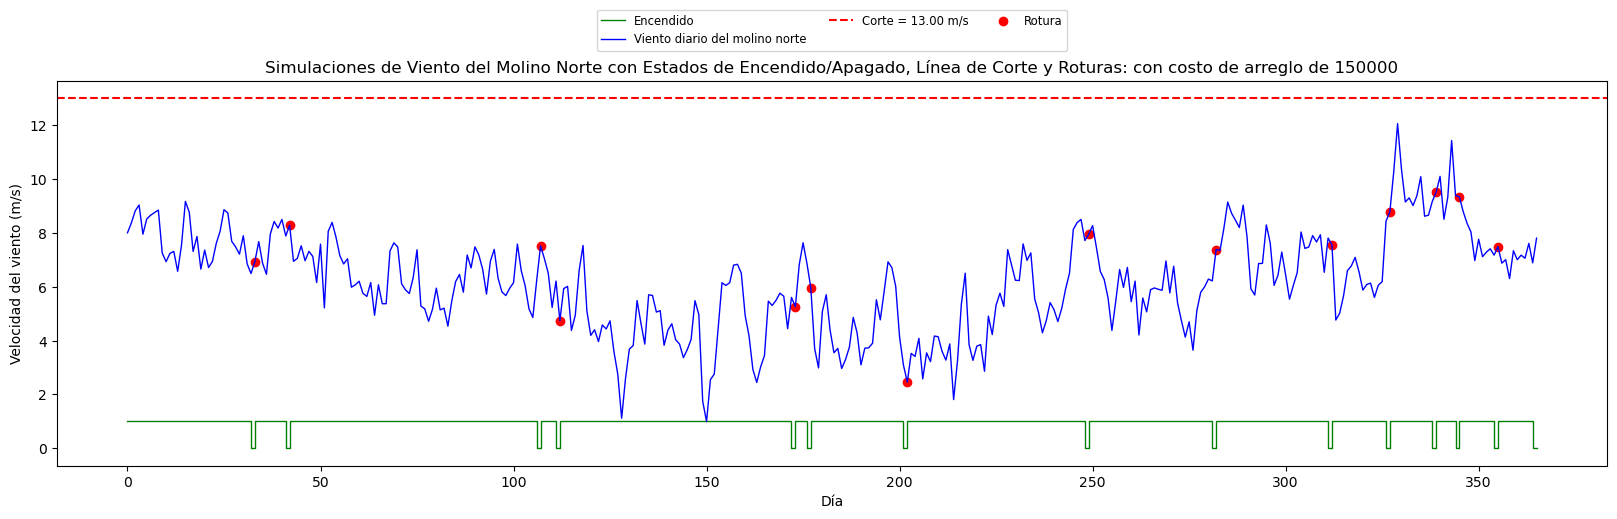

In [399]:

cashflowNorte, encendidosNorte, apagadosNorte, roturasNorte_150, simulacionNorte, van_150 = simular_molino(datos, kappa, sigma, delta, gamma, beta, 1, umbral_optimo150[0], "norte",150000)
# Días del año
dias = np.arange(0, 366)

plt.figure(figsize=(20, 5))

# Graficar el estado de encendido con líneas o puntos (verde para encendido)
plt.step(dias, encendidosNorte[0], color="green", label="Encendido", where="pre", linestyle='-', linewidth=1)

# Plot de la simulación del viento encima de los gráficos de encendido/apagado
plt.plot(simulacionNorte[0], label="Viento diario del molino norte", color="blue", linewidth=1)

# Graficar la línea de corte (umbral)
plt.axhline(y=umbral_optimo150[0], color='r', linestyle='--', label=f"Corte = {umbral_optimo150[0]:.2f} m/s")

# Añadir puntos donde hay roturas (donde roturasNorte es 1)
rotura_dias = dias[roturasNorte_150[0] == 1]
rotura_viento = simulacionNorte[0][roturasNorte_150[0] == 1]
plt.scatter(rotura_dias, rotura_viento, color="red", label="Rotura", zorder=1)

# Añadir títulos y leyenda
plt.title("Simulaciones de Viento del Molino Norte con Estados de Encendido/Apagado, Línea de Corte y Roturas: con costo de arreglo de 150000")
plt.xlabel("Día")
plt.ylabel("Velocidad del viento (m/s)")
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=3, fontsize='small')

# Mostrar gráfico
plt.show()



Sospechabamos que como el costo de roturas es más bajo, le iba a terminar conveniendo que estuviera prendido aunque se rompiera más seguido. Se fue a un threshold parecido al de la simulación ingenua, con un umbral tan alto que hace que no se apague nunca. 

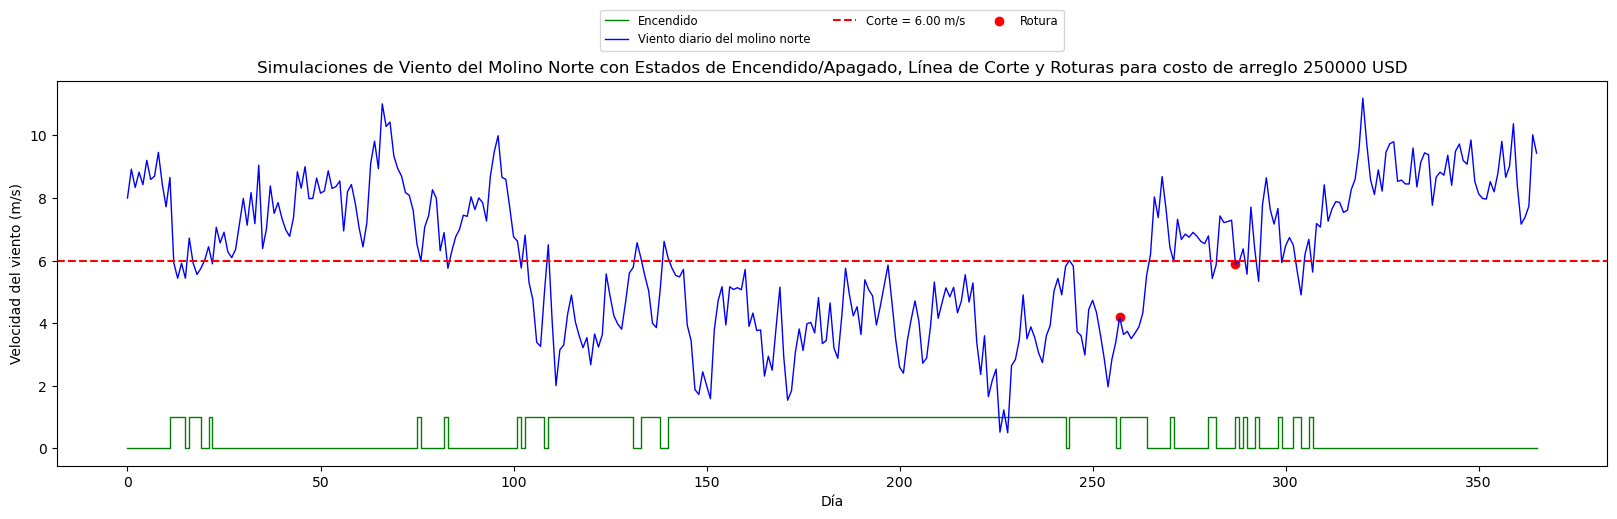

In [400]:

cashflowNorte, encendidosNorte, apagadosNorte, roturasNorte_250, simulacionNorte, van_250 = simular_molino(datos, kappa, sigma, delta, gamma, beta, 1, umbral_optimo250[0], "norte",250000)
# Días del año
dias = np.arange(0, 366)

plt.figure(figsize=(20, 5))

# Graficar el estado de encendido con líneas o puntos (verde para encendido)
plt.step(dias, encendidosNorte[0], color="green", label="Encendido", where="pre", linestyle='-', linewidth=1)

# Plot de la simulación del viento encima de los gráficos de encendido/apagado
plt.plot(simulacionNorte[0], label="Viento diario del molino norte", color="blue", linewidth=1)


# Graficar la línea de corte (umbral)
plt.axhline(y=umbral_optimo250[0], color='r', linestyle='--', label=f"Corte = {umbral_optimo250[0]:.2f} m/s")

# Añadir puntos donde hay roturas (donde roturasNorte es 1)
rotura_dias = dias[roturasNorte_250[0] == 1]
rotura_viento = simulacionNorte[0][roturasNorte_250[0] == 1]
plt.scatter(rotura_dias, rotura_viento, color="red", label="Rotura", zorder=1)

# Añadir títulos y leyenda
plt.title("Simulaciones de Viento del Molino Norte con Estados de Encendido/Apagado, Línea de Corte y Roturas para costo de arreglo 250000 USD")
plt.xlabel("Día")
plt.ylabel("Velocidad del viento (m/s)")
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=3, fontsize='small')

# Mostrar gráfico
plt.show()

En este caso, como le cuesta más cada vez que se rompe, se cuida más y baja el umbral.

### Ejercicio 14: Sensibilidad del VAN a la media estacional
Como simulamos los molinos con variaciones en el theta (que es nuestra media estacional), le restamos y le agregamos un valor epshilon que en este caso es 1.

In [408]:
#Calculo de theta
delta = 1/365
def theta_2(t_i,variacion):
    resultado:float = 6 + 2 * np.cos(2 * np.pi *t_i /365) + variacion
    return resultado

Simulamos entonces nuevos vientos con estas variaciones

In [409]:

def simulacion_regional_wind_2(S_0, kappa, sigma, delta, T, caminos,variacion):   
    #Inicializamos matriz S(M CAMINOS * T TIEMPOS)
    S=np.zeros((caminos,T+1))
    #ponemos en todas las filas primera posición el so
    S[:,0]=S_0
    #para cada fila
    for camino in range (caminos):
        #calculamos todos los tiempos
        for i in range(1,T+1):
            #pongo el maximo entre 0 y el estimado por si llegara a darme negativo algún viento
            S[camino,i]=max(0,S[camino,i-1]+kappa*(theta_2(i,variacion)-S[camino,i-1])*delta+(sigma*np.sqrt(delta)*np.random.normal(0,1)))
    return S


def simulacion_viento_molinos_2(S_0, D_0,kappa,sigma,delta,gamma,beta,T,caminos,variacion):
    S = simulacion_regional_wind_2(S_0,kappa,sigma,delta,T,caminos,variacion)
    D = simulacion_wind_gap_norte_sur(D_0,beta,gamma,delta,T,caminos)
    S_Molino_Sur = (S[:,:] + 0.5*D[:,:])
    S_Molino_Norte = (S[:,:] - 0.5*D[:,:])
    return S_Molino_Norte, S_Molino_Sur


In [410]:
# Simulación del molino de viento basado en probabilidad de rotura
def simular_molino_2(datos, kappa, sigma, delta, gamma, beta, simulaciones, K, molino,arreglo,variacion):
    cashflow = np.zeros((simulaciones,366))
    roturas = np.zeros((simulaciones,366))
    encendidos = np.zeros((simulaciones,366))
    apagados = np.zeros((simulaciones,366))
    Van=np.zeros((simulaciones,366))
    # Simulación de viento para ambos molinos
    S_molino_norte, S_molino_sur = simulacion_viento_molinos_2(datos["regional wind"][0], datos["wind gap norte sur"][0], kappa, sigma, delta, gamma, beta, 365, simulaciones,variacion)
    
    # Selección del molino
    if molino == "sur":
        S = S_molino_sur
    elif molino =="norte":
        S = S_molino_norte
    
    prendido = False  # Estado inicial del molino (apagado)
    proba_corte=proba_deRomperse(K)   
    # Simulación día a día
    for simulacion in range(0,simulaciones):
        for dia in range(0, 365):
            tasa_descuento=np.exp(-0.05*dia/365)
            s_i = S[simulacion,dia]  # Velocidad media del viento en el día actual
            proba = proba_deRomperse(s_i)  # Probabilidad de rotura en función de la velocidad del viento s_i
            # Encender el molino si está apagado y la probabilidad de rotura es menor que K
            if not prendido and proba < proba_corte:
                prendido = True
            
            # Si el molino está encendido
            if prendido:
                # Apagar el molino si la probabilidad de rotura supera el umbral K
                if proba >= proba_corte:
                    prendido = False
                    cashflow[simulacion,dia] = -1000  # Penalización por apagado
                # Si se rompe
                elif proba > np.random.uniform(0,1) and roturas[simulacion,dia - 1] != 1:  # Asegurarse de que no haya rotura el día anterior
                    prendido = False
                    cashflow[simulacion,dia] = -arreglo  # Costo de la rotura
                    roturas[simulacion,dia] = 1
                # Si funciona normalmente
                else:
                    cashflow[simulacion,dia] = s_i * 1000  # Ganancia por funcionamiento
                    
            # Actualizar estados de encendido y apagado
            if not prendido:
                apagados[simulacion,dia] = 1
            else:
                encendidos[simulacion,dia] = 1
            
            Van[simulacion,dia]= cashflow[simulacion,dia]*tasa_descuento
        
        
    return cashflow, encendidos, apagados, roturas, S, Van


In [428]:
def maximizarThreshold_2(datos,simulaciones,costo,molino,variacion):
    threshold=0
    mejorthreshold=0
    mejorVAN=0
    van_actual=0
    thresholds=[]
    vans=[]
    while threshold<14:
        simulacionNorte=simular_molino_2(datos,kappa,sigma,delta,gamma,beta,simulaciones,threshold,molino,costo,variacion)
        van_actual=EsperanzaVAN_individual(simulacionNorte[5])[0]
        if(van_actual>=mejorVAN):
            mejorVAN=van_actual
            mejorthreshold=threshold
        vans.append(van_actual)
        thresholds.append(threshold)
        threshold+=0.5
    return mejorthreshold,mejorVAN,thresholds,vans


In [431]:
variacion_theta = 2

#Buscamos el valor optimizado del umbral para las simulaciones
simulacion_sensibilidad_norte_menor_theta = simular_molino_2(datos,kappa,sigma,delta,gamma,beta,10000,threshold_optimo_norte[0],"norte",200000,-variacion_theta)
simulacion_sensibilidad_norte_mayor_theta = simular_molino_2(datos,kappa,sigma,delta,gamma,beta,10000,threshold_optimo_norte[0],"norte",200000,variacion_theta)

simulacion_sensibilidad_sur_menor_theta = simular_molino_2(datos,kappa,sigma,delta,gamma,beta,10000,threshold_optimo_sur[0],"sur",200000,-variacion_theta)
simulacion_sensibilidad_sur_mayor_theta = simular_molino_2(datos,kappa,sigma,delta,gamma,beta,10000,threshold_optimo_sur[0],"sur",200000,variacion_theta)




# Aquellos que tienen menor media estacional
van_menor_thetaNorte = EsperanzaVAN_individual(simulacion_sensibilidad_norte_menor_theta[5])
van_menor_thetaSur=EsperanzaVAN_individual(simulacion_sensibilidad_sur_menor_theta[5])


# Aquellos que tienen mayor media estacional
van_mayor_thetaNorte = EsperanzaVAN_individual(simulacion_sensibilidad_norte_mayor_theta[5])
van_mayor_thetaSur= EsperanzaVAN_individual(simulacion_sensibilidad_sur_mayor_theta[5])




In [432]:

esperanza_van_menor_theta = EsperanzaVANTotal(van_menor_thetaNorte,van_menor_thetaSur)[0]
esperanza_van_mayor_theta = EsperanzaVANTotal(van_mayor_thetaNorte,van_mayor_thetaSur)[0]

sensibilidad_media_estacional = (esperanza_van_mayor_theta - esperanza_van_menor_theta)/(2*variacion_theta)
print("La sensibilidad del Van al valor de theta es: " +str(sensibilidad_media_estacional))

# Calculamos el promedio del van para los camino

La sensibilidad del Van al valor de theta es: -187260.0047083661


Graficamos el van en base a la variación del theta

In [436]:
vanes_esperados_mas = []
vanes_esperados_menos = []
variaciones_media = [0,1,2,3,4]
for variacion in variaciones_media:

    simulacion_sensibilidad_norte_menor_theta = simular_molino_2(datos,kappa,sigma,delta,gamma,beta,10000, threshold_optimo_norte[0],"norte",200000,-variacion)
    simulacion_sensibilidad_norte_mayor_theta = simular_molino_2(datos,kappa,sigma,delta,gamma,beta,10000, threshold_optimo_norte[0],"norte",200000,variacion)

    simulacion_sensibilidad_sur_menor_theta = simular_molino_2(datos,kappa,sigma,delta,gamma,beta,10000, threshold_optimo_sur[0],"sur",200000,-variacion)
    simulacion_sensibilidad_sur_mayor_theta = simular_molino_2(datos,kappa,sigma,delta,gamma,beta,10000, threshold_optimo_sur[0],"sur",200000,variacion)

    # Aquellos que tienen menor media estacional
    van_menor_thetaNorte = EsperanzaVAN_individual(simulacion_sensibilidad_norte_menor_theta[5])
    van_menor_thetaSur=EsperanzaVAN_individual(simulacion_sensibilidad_sur_menor_theta[5])


    # Aquellos que tienen mayor media estacional
    van_mayor_thetaNorte = EsperanzaVAN_individual(simulacion_sensibilidad_norte_mayor_theta[5])
    van_mayor_thetaSur= EsperanzaVAN_individual(simulacion_sensibilidad_sur_mayor_theta[5])
    esperanza_van_menor_theta = EsperanzaVANTotal(van_menor_thetaNorte,van_menor_thetaSur)[0]
    esperanza_van_mayor_theta = EsperanzaVANTotal(van_mayor_thetaNorte,van_mayor_thetaSur)[0]
    vanes_esperados_mas.append(esperanza_van_mayor_theta)
    vanes_esperados_menos.append(esperanza_van_menor_theta)
    
print(vanes_esperados_menos)
print(vanes_esperados_mas)



    

[574629.4725292838, 798886.6281939722, 915159.1949590265, 904960.1780463071, 800953.3677394486]
[588949.1354640898, 367493.76563761535, 185063.87210188957, 49619.64697881523, 559.7821057455047]


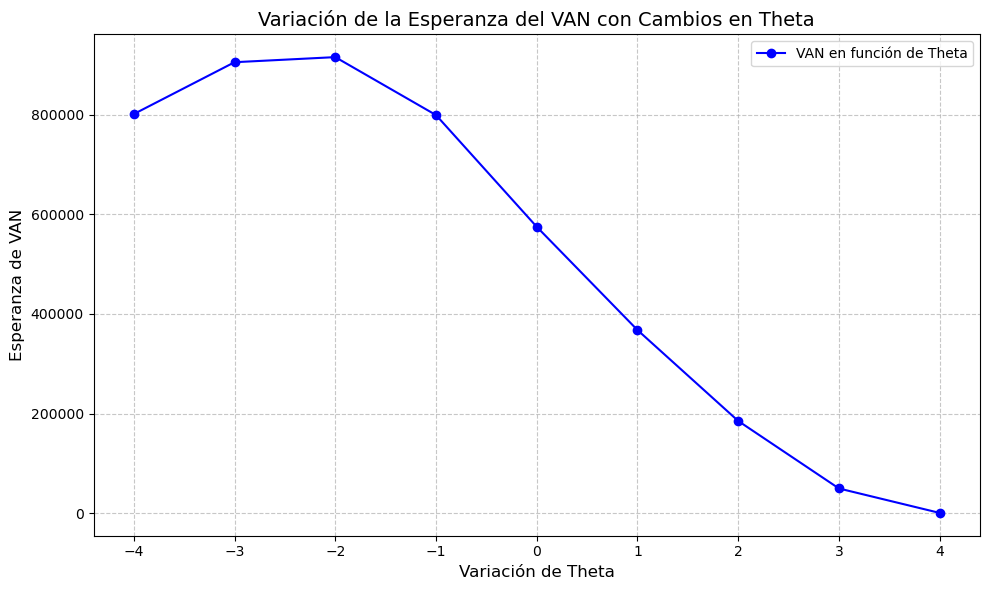

In [437]:
# Invertimos los valores negativos de la variación para el eje x
variaciones_negativas = [-v for v in variaciones_media]

# Unimos las variaciones negativas y positivas en una única lista
variaciones_totales = variaciones_negativas[::-1] + variaciones_media[1:]
vanes_totales = vanes_esperados_menos[::-1] + vanes_esperados_mas[1:]

# Crear el gráfico
plt.figure(figsize=(10, 6))

# Graficar una única línea para theta + y -
plt.plot(variaciones_totales, vanes_totales, color='blue', marker='o', linestyle='-', label='VAN en función de Theta')

# Añadir etiquetas y título
plt.xlabel('Variación de Theta', fontsize=12)
plt.ylabel('Esperanza de VAN', fontsize=12)
plt.title('Variación de la Esperanza del VAN con Cambios en Theta', fontsize=14)

# Añadir una cuadrícula
plt.grid(True, linestyle='--', alpha=0.7)

# Añadir leyenda
plt.legend()

# Mostrar el gráfico
plt.tight_layout()
plt.show()

Al variar 𝜃, que en este caso corresponde a la media estacional del modelo, se observan diferentes efectos en el comportamiento del molino. Si la velocidad del viento disminuye, el molino tendrá más dificultades para alcanzar el threshold óptimo originalmente establecido, lo que resultará en que se apague menos frecuentemente y, por ende, generará más ingresos. Por el contrario, si la velocidad del viento aumenta, el molino estará apagado durante más días, ya que el threshold anterior impedirá que se encienda con la misma frecuencia. Este comportamiento es evidente en el gráfico adjunto, donde se refleja cómo la variación en la velocidad del viento impacta directamente en el funcionamiento del molino y sus resultados económicos.